<a href="https://colab.research.google.com/github/Kakkarot217/gans/blob/master/GAN_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torchvision tensorboardx jupyter matplotlib numpy

     |████████████████████████████████| 194kB 49.2MB/s 


In [0]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [0]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch
class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [4]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5,),(.5,))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

0it [00:00, ?it/s]

9920512it [00:03, 3167128.80it/s]                             


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 48505.06it/s]                           
0it [00:00, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw


1654784it [00:02, 821638.11it/s]                             
0it [00:00, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw


8192it [00:00, 18386.37it/s]            

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw
Processing...
Done!


In [0]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

In [0]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [0]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
generator = GeneratorNet()

In [0]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

In [0]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [0]:
loss = nn.BCELoss()

In [0]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [0]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)

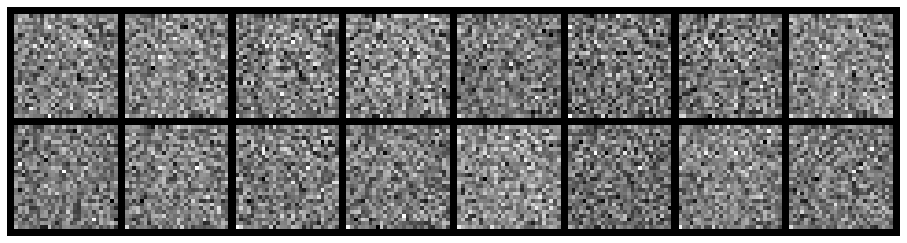

Epoch: [0/25], Batch Num: [0/600]
Discriminator Loss: 1.3780, Generator Loss: 0.6701
D(x): 0.5164, D(G(z)): 0.5117


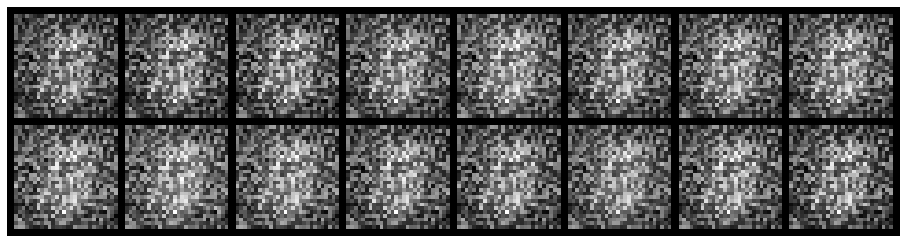

Epoch: [0/25], Batch Num: [100/600]
Discriminator Loss: 1.7422, Generator Loss: 1.1403
D(x): 0.5720, D(G(z)): 0.5495


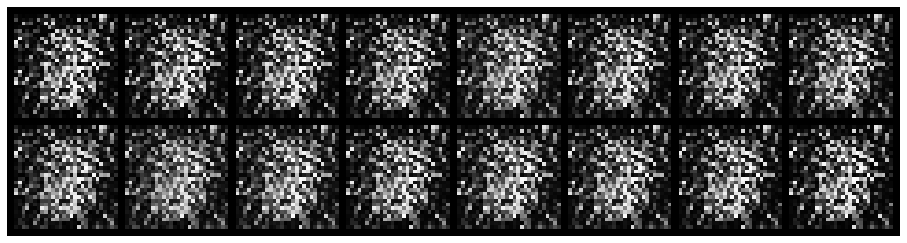

Epoch: [0/25], Batch Num: [200/600]
Discriminator Loss: 1.6050, Generator Loss: 1.9199
D(x): 0.7683, D(G(z)): 0.6383


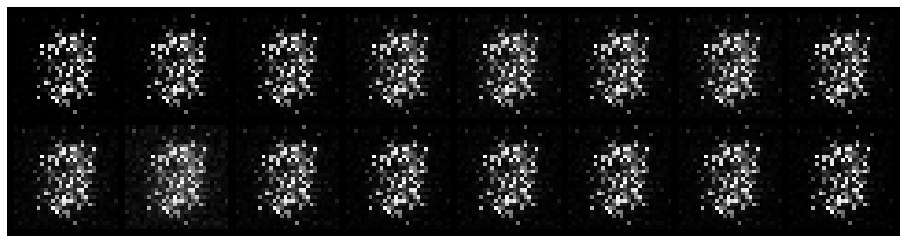

Epoch: [0/25], Batch Num: [300/600]
Discriminator Loss: 0.1969, Generator Loss: 3.3306
D(x): 0.9120, D(G(z)): 0.0837


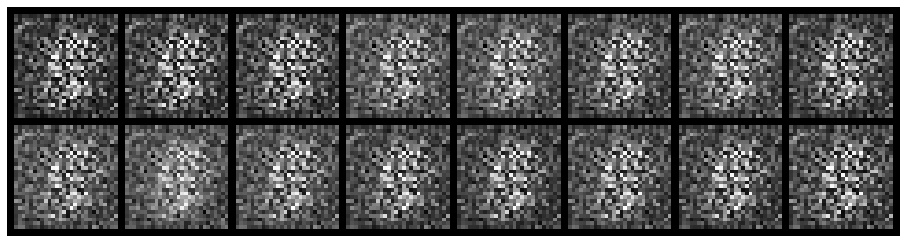

Epoch: [0/25], Batch Num: [400/600]
Discriminator Loss: 1.4395, Generator Loss: 1.2646
D(x): 0.5853, D(G(z)): 0.5272


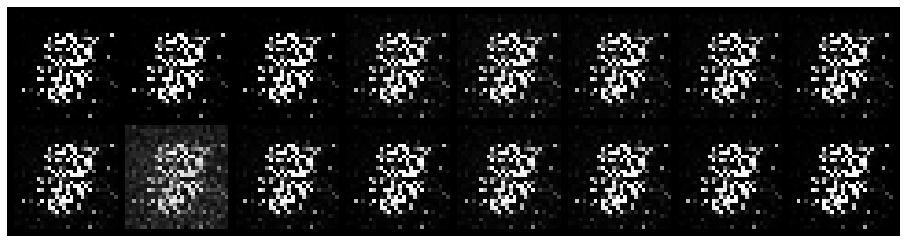

Epoch: [0/25], Batch Num: [500/600]
Discriminator Loss: 0.2461, Generator Loss: 5.2879
D(x): 0.9038, D(G(z)): 0.0915


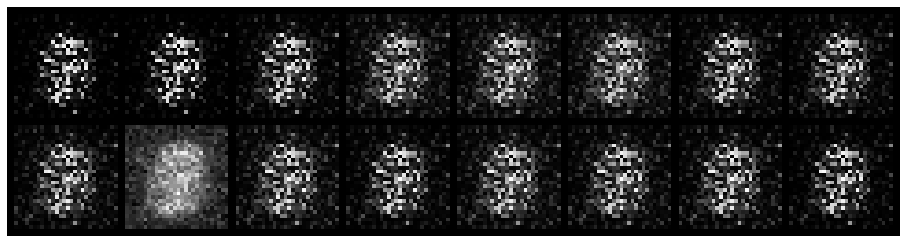

Epoch: [1/25], Batch Num: [0/600]
Discriminator Loss: 1.1674, Generator Loss: 3.0765
D(x): 0.6895, D(G(z)): 0.3733


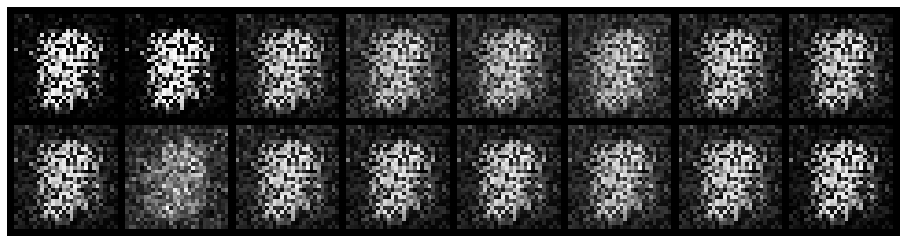

Epoch: [1/25], Batch Num: [100/600]
Discriminator Loss: 0.9306, Generator Loss: 1.7816
D(x): 0.7112, D(G(z)): 0.3996


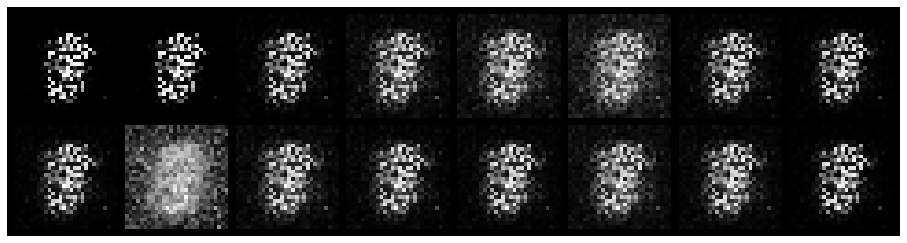

Epoch: [1/25], Batch Num: [200/600]
Discriminator Loss: 0.6702, Generator Loss: 3.7961
D(x): 0.7442, D(G(z)): 0.2114


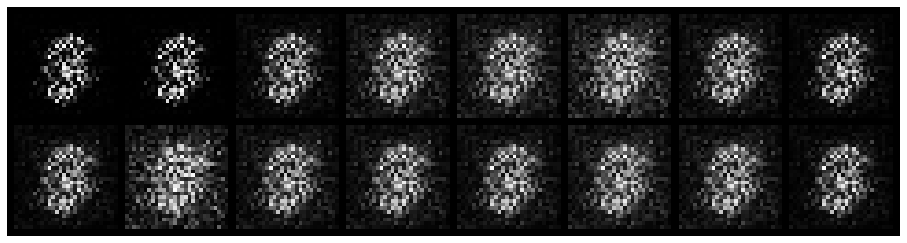

Epoch: [1/25], Batch Num: [300/600]
Discriminator Loss: 0.6739, Generator Loss: 3.2432
D(x): 0.6851, D(G(z)): 0.1794


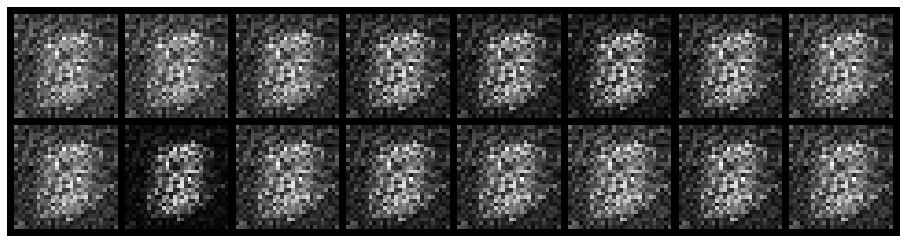

Epoch: [1/25], Batch Num: [400/600]
Discriminator Loss: 0.2450, Generator Loss: 3.6966
D(x): 0.8917, D(G(z)): 0.1038


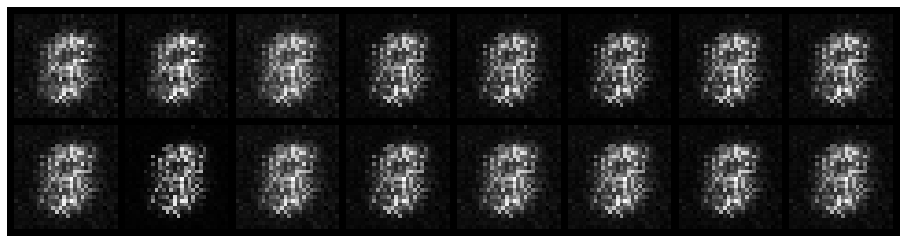

Epoch: [1/25], Batch Num: [500/600]
Discriminator Loss: 1.2069, Generator Loss: 1.3953
D(x): 0.6780, D(G(z)): 0.4745


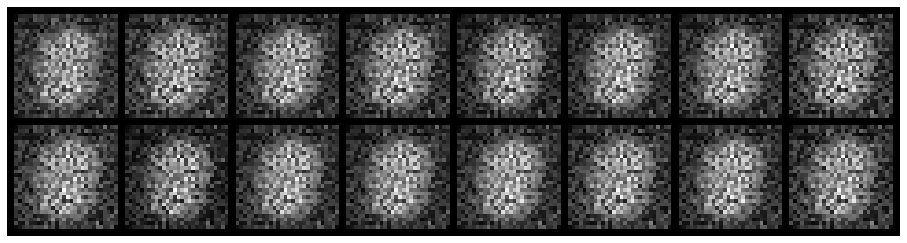

Epoch: [2/25], Batch Num: [0/600]
Discriminator Loss: 0.7926, Generator Loss: 1.1906
D(x): 0.7828, D(G(z)): 0.4061


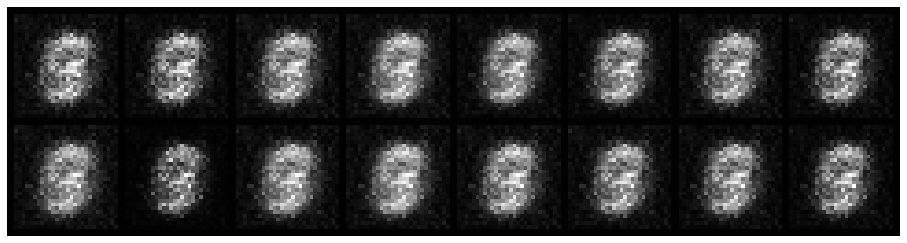

Epoch: [2/25], Batch Num: [100/600]
Discriminator Loss: 0.9805, Generator Loss: 1.8272
D(x): 0.6712, D(G(z)): 0.3458


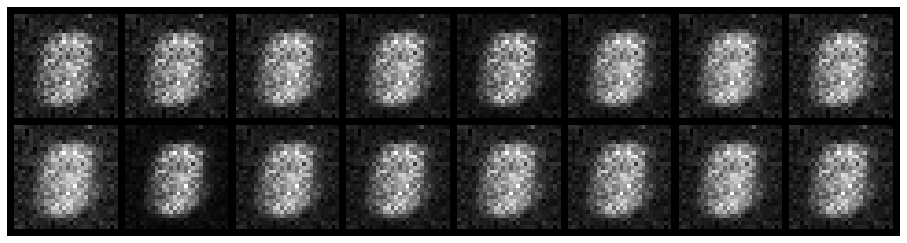

Epoch: [2/25], Batch Num: [200/600]
Discriminator Loss: 1.0782, Generator Loss: 1.2236
D(x): 0.6568, D(G(z)): 0.3916


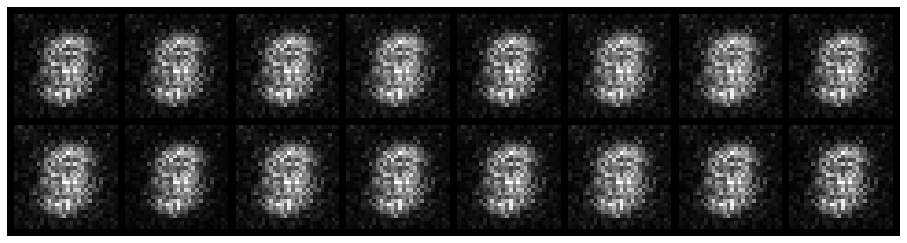

Epoch: [2/25], Batch Num: [300/600]
Discriminator Loss: 1.0633, Generator Loss: 1.2267
D(x): 0.7420, D(G(z)): 0.4485


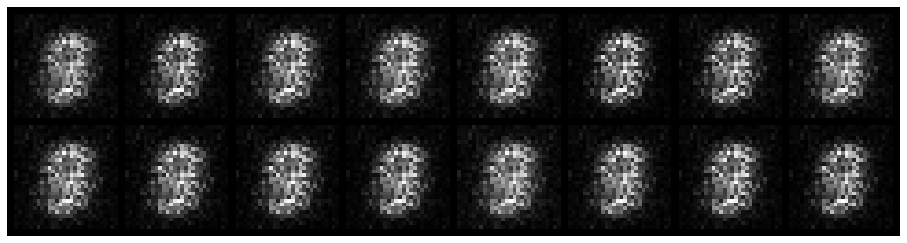

Epoch: [2/25], Batch Num: [400/600]
Discriminator Loss: 0.3926, Generator Loss: 2.4798
D(x): 0.7967, D(G(z)): 0.1319


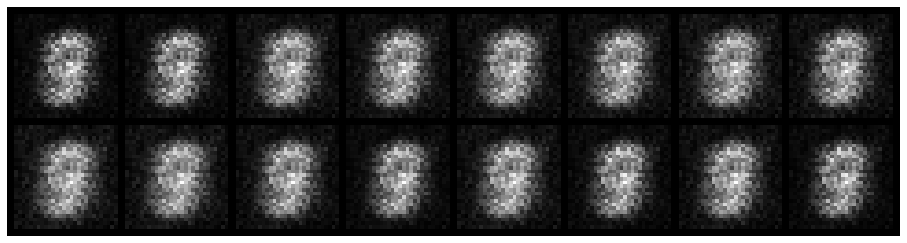

Epoch: [2/25], Batch Num: [500/600]
Discriminator Loss: 0.3459, Generator Loss: 2.8433
D(x): 0.8989, D(G(z)): 0.1652


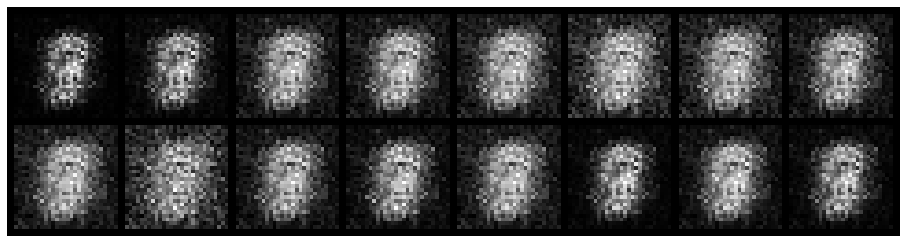

Epoch: [3/25], Batch Num: [0/600]
Discriminator Loss: 0.4567, Generator Loss: 3.2284
D(x): 0.8666, D(G(z)): 0.1416


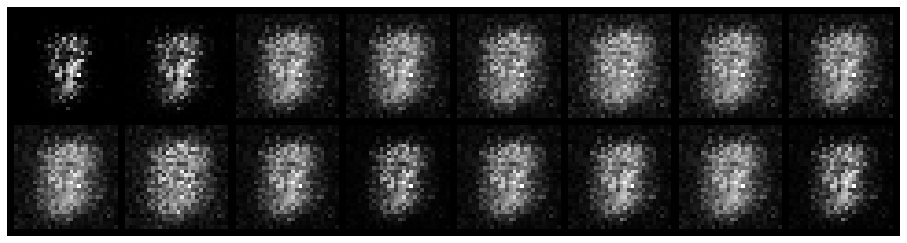

Epoch: [3/25], Batch Num: [100/600]
Discriminator Loss: 0.4880, Generator Loss: 2.3524
D(x): 0.9124, D(G(z)): 0.2190


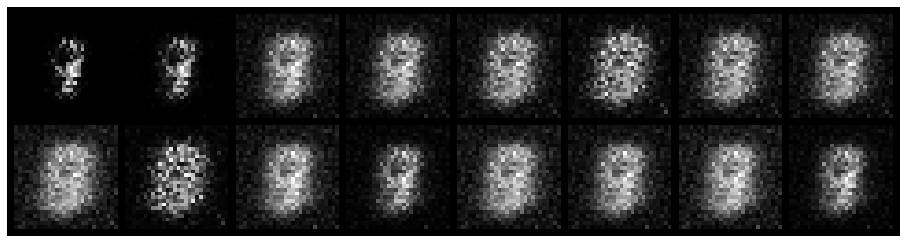

Epoch: [3/25], Batch Num: [200/600]
Discriminator Loss: 0.2765, Generator Loss: 4.3900
D(x): 0.9074, D(G(z)): 0.0870


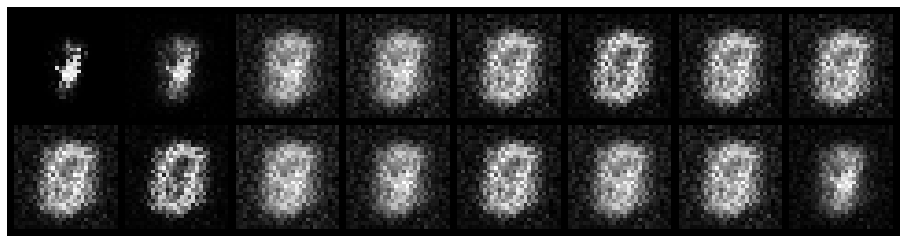

Epoch: [3/25], Batch Num: [300/600]
Discriminator Loss: 0.4284, Generator Loss: 2.8636
D(x): 0.9078, D(G(z)): 0.1913


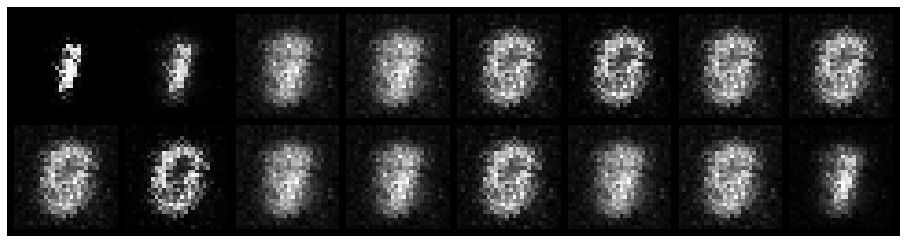

Epoch: [3/25], Batch Num: [400/600]
Discriminator Loss: 0.4229, Generator Loss: 2.8371
D(x): 0.8840, D(G(z)): 0.1786


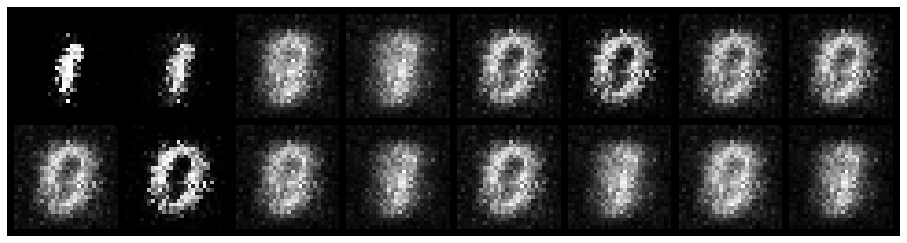

Epoch: [3/25], Batch Num: [500/600]
Discriminator Loss: 0.2687, Generator Loss: 3.1997
D(x): 0.9095, D(G(z)): 0.0844


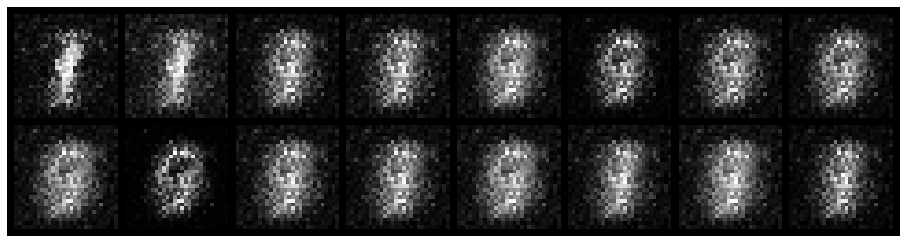

Epoch: [4/25], Batch Num: [0/600]
Discriminator Loss: 0.3474, Generator Loss: 3.9292
D(x): 0.9140, D(G(z)): 0.0922


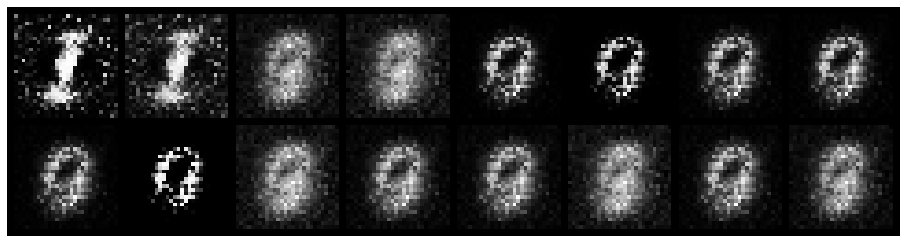

Epoch: [4/25], Batch Num: [100/600]
Discriminator Loss: 1.0895, Generator Loss: 2.6649
D(x): 0.7198, D(G(z)): 0.2113


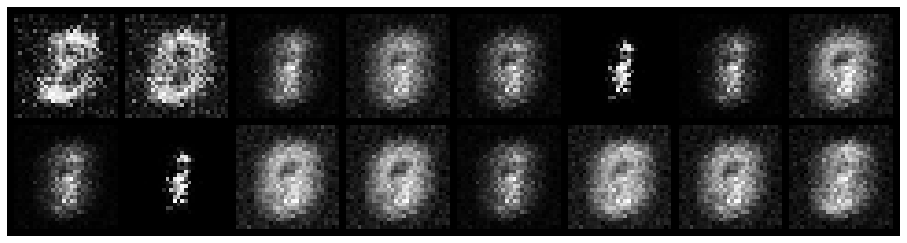

Epoch: [4/25], Batch Num: [200/600]
Discriminator Loss: 0.6105, Generator Loss: 3.3273
D(x): 0.8675, D(G(z)): 0.1983


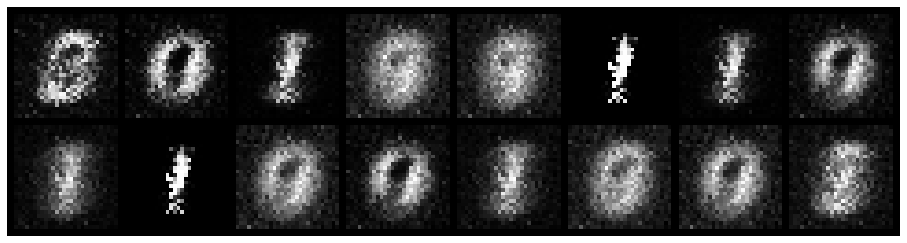

Epoch: [4/25], Batch Num: [300/600]
Discriminator Loss: 0.3414, Generator Loss: 4.1036
D(x): 0.9429, D(G(z)): 0.1427


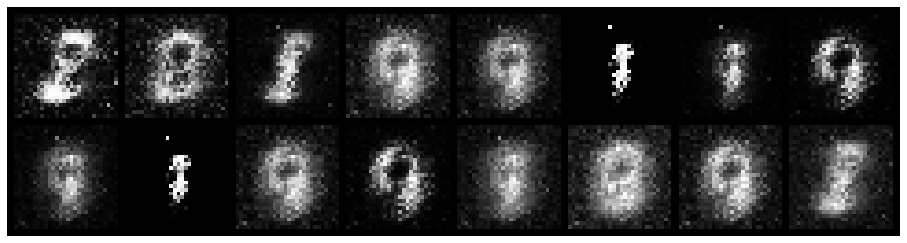

Epoch: [4/25], Batch Num: [400/600]
Discriminator Loss: 0.3693, Generator Loss: 4.5210
D(x): 0.8978, D(G(z)): 0.0614


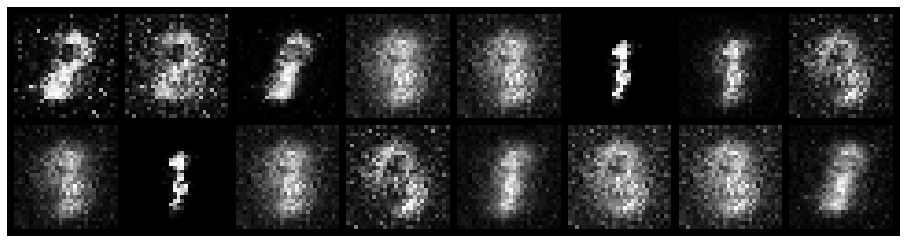

Epoch: [4/25], Batch Num: [500/600]
Discriminator Loss: 0.3308, Generator Loss: 3.6385
D(x): 0.9237, D(G(z)): 0.1329


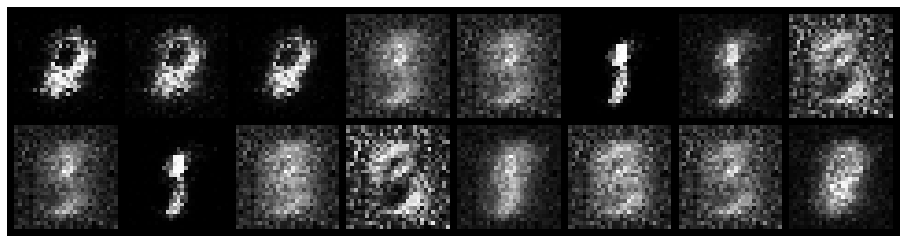

Epoch: [5/25], Batch Num: [0/600]
Discriminator Loss: 0.4127, Generator Loss: 2.8799
D(x): 0.9228, D(G(z)): 0.1951


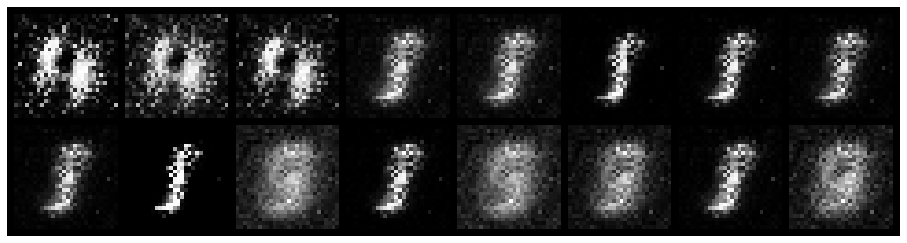

Epoch: [5/25], Batch Num: [100/600]
Discriminator Loss: 0.2067, Generator Loss: 3.1071
D(x): 0.9491, D(G(z)): 0.1058


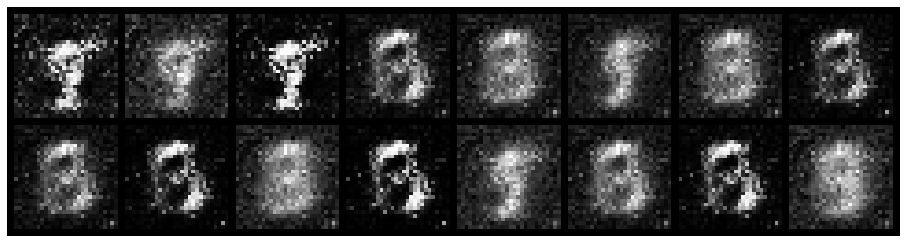

Epoch: [5/25], Batch Num: [200/600]
Discriminator Loss: 0.6645, Generator Loss: 2.7557
D(x): 0.7626, D(G(z)): 0.0868


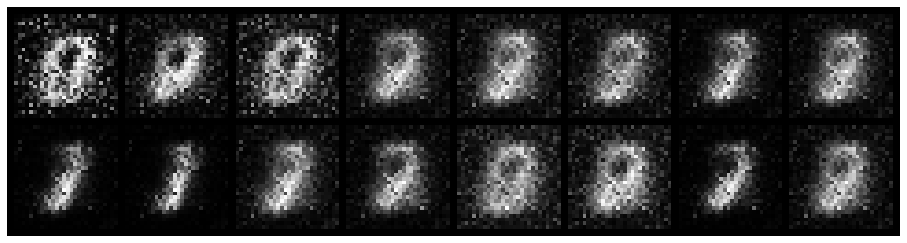

Epoch: [5/25], Batch Num: [300/600]
Discriminator Loss: 0.7829, Generator Loss: 2.2928
D(x): 0.7604, D(G(z)): 0.2133


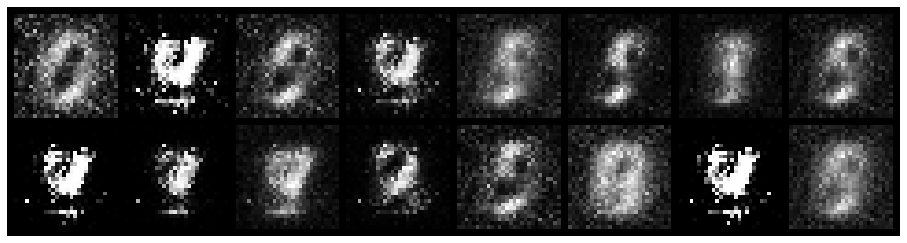

Epoch: [5/25], Batch Num: [400/600]
Discriminator Loss: 0.7156, Generator Loss: 2.4683
D(x): 0.8337, D(G(z)): 0.2727


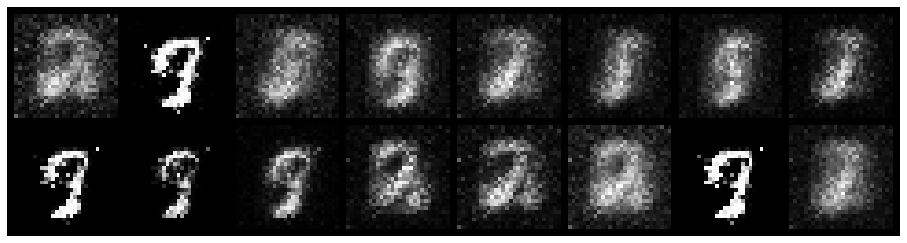

Epoch: [5/25], Batch Num: [500/600]
Discriminator Loss: 0.3258, Generator Loss: 3.4283
D(x): 0.9141, D(G(z)): 0.1426


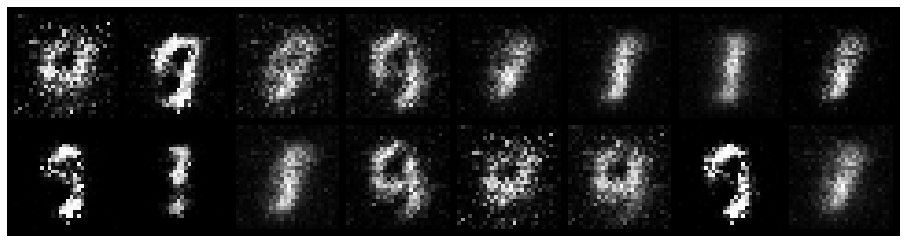

Epoch: [6/25], Batch Num: [0/600]
Discriminator Loss: 0.4438, Generator Loss: 3.6263
D(x): 0.8166, D(G(z)): 0.0541


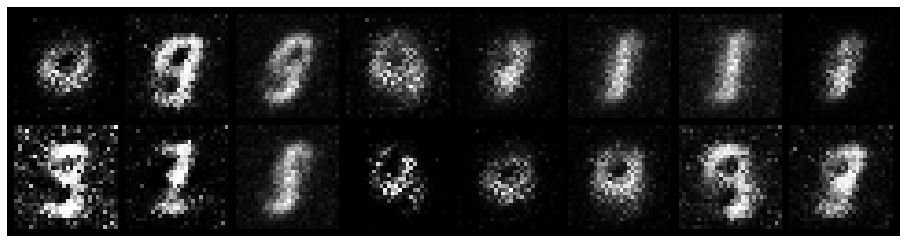

Epoch: [6/25], Batch Num: [100/600]
Discriminator Loss: 0.8963, Generator Loss: 2.5484
D(x): 0.6911, D(G(z)): 0.1590


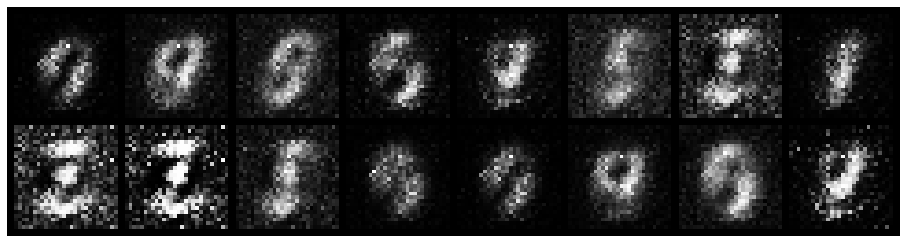

Epoch: [6/25], Batch Num: [200/600]
Discriminator Loss: 0.4153, Generator Loss: 2.6461
D(x): 0.8837, D(G(z)): 0.1328


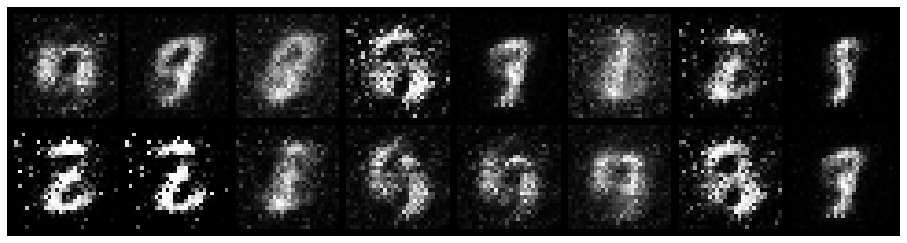

Epoch: [6/25], Batch Num: [300/600]
Discriminator Loss: 0.3469, Generator Loss: 4.5400
D(x): 0.8678, D(G(z)): 0.0851


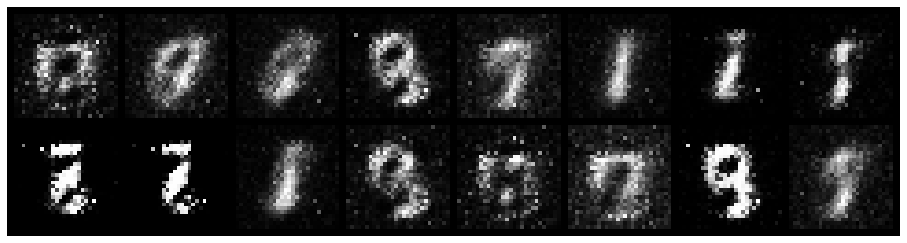

Epoch: [6/25], Batch Num: [400/600]
Discriminator Loss: 0.6302, Generator Loss: 2.4967
D(x): 0.8559, D(G(z)): 0.2204


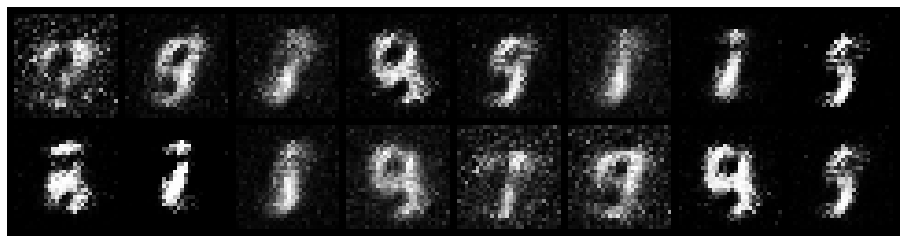

Epoch: [6/25], Batch Num: [500/600]
Discriminator Loss: 0.3098, Generator Loss: 3.2429
D(x): 0.9178, D(G(z)): 0.1087


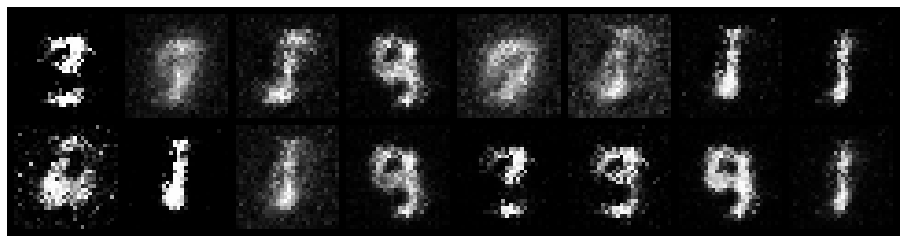

Epoch: [7/25], Batch Num: [0/600]
Discriminator Loss: 0.8320, Generator Loss: 2.8455
D(x): 0.8155, D(G(z)): 0.2500


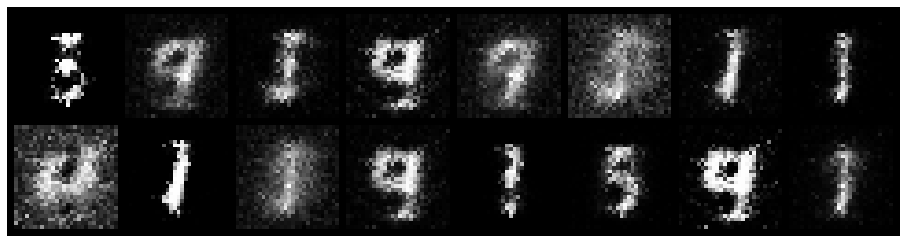

Epoch: [7/25], Batch Num: [100/600]
Discriminator Loss: 0.7081, Generator Loss: 2.6418
D(x): 0.8240, D(G(z)): 0.2303


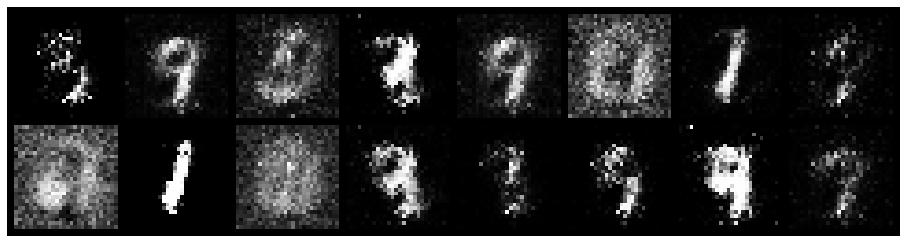

Epoch: [7/25], Batch Num: [200/600]
Discriminator Loss: 0.3462, Generator Loss: 3.1546
D(x): 0.8957, D(G(z)): 0.1337


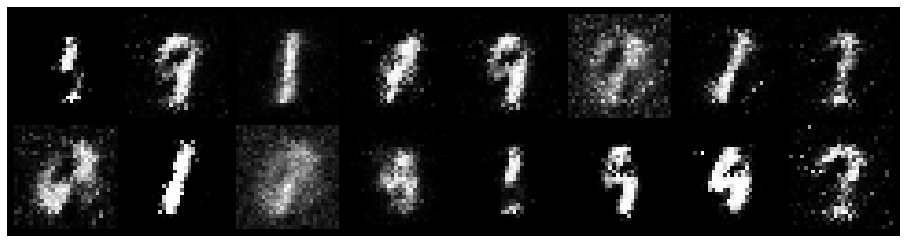

Epoch: [7/25], Batch Num: [300/600]
Discriminator Loss: 0.8165, Generator Loss: 2.5614
D(x): 0.7597, D(G(z)): 0.2221


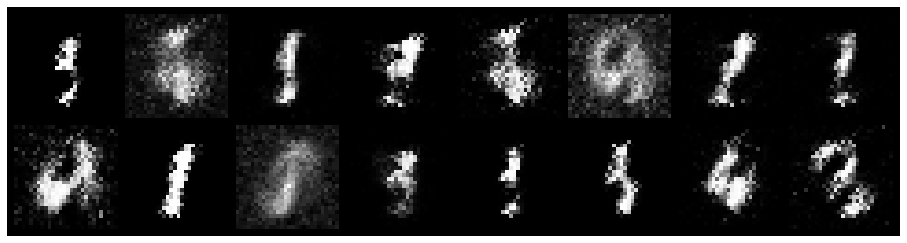

Epoch: [7/25], Batch Num: [400/600]
Discriminator Loss: 0.7098, Generator Loss: 2.5656
D(x): 0.7975, D(G(z)): 0.2259


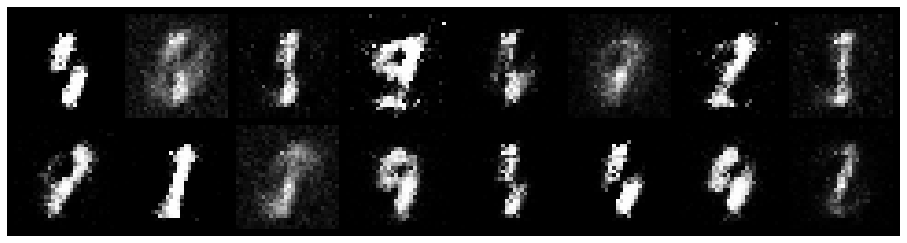

Epoch: [7/25], Batch Num: [500/600]
Discriminator Loss: 0.5531, Generator Loss: 3.0121
D(x): 0.8648, D(G(z)): 0.1723


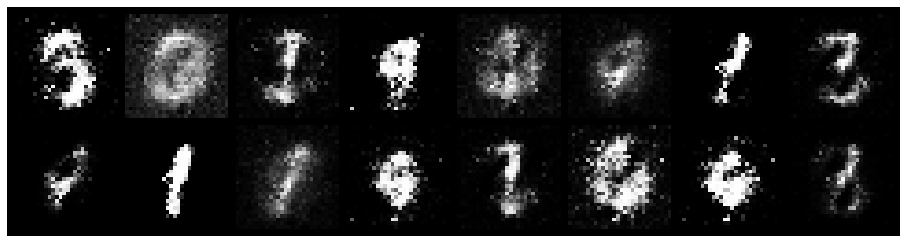

Epoch: [8/25], Batch Num: [0/600]
Discriminator Loss: 0.5341, Generator Loss: 2.8547
D(x): 0.8339, D(G(z)): 0.1747


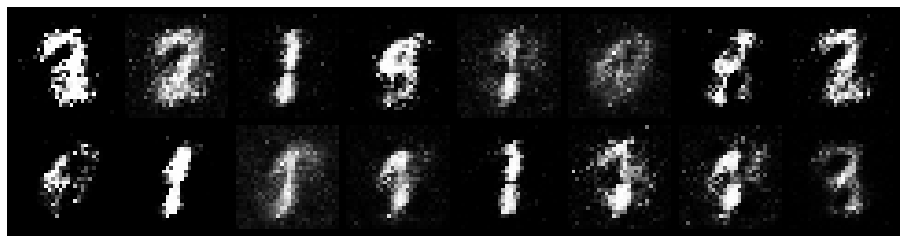

Epoch: [8/25], Batch Num: [100/600]
Discriminator Loss: 0.5504, Generator Loss: 2.2973
D(x): 0.8606, D(G(z)): 0.2328


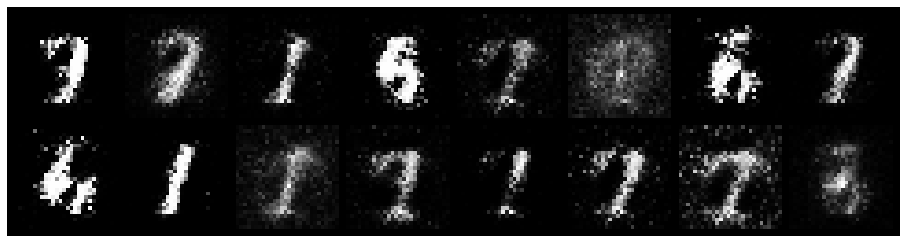

Epoch: [8/25], Batch Num: [200/600]
Discriminator Loss: 0.3814, Generator Loss: 3.0124
D(x): 0.8826, D(G(z)): 0.1706


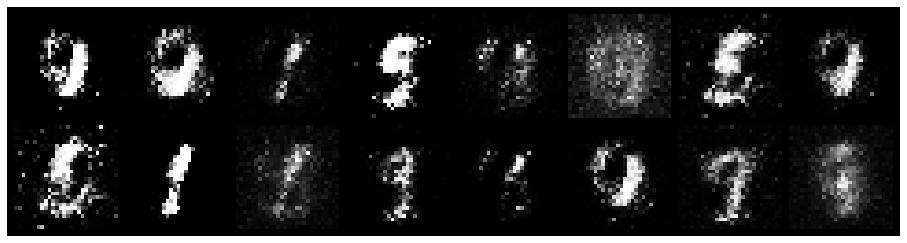

Epoch: [8/25], Batch Num: [300/600]
Discriminator Loss: 0.5774, Generator Loss: 2.5995
D(x): 0.8341, D(G(z)): 0.1875


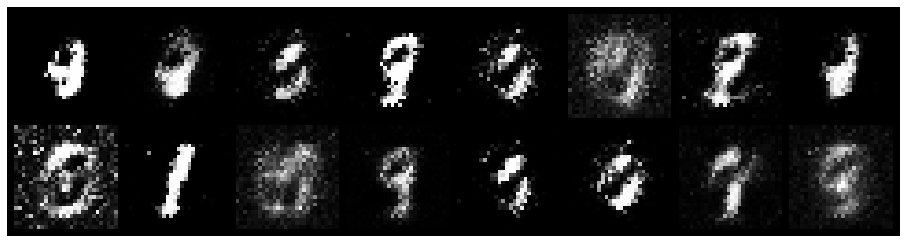

Epoch: [8/25], Batch Num: [400/600]
Discriminator Loss: 0.5347, Generator Loss: 2.6928
D(x): 0.8441, D(G(z)): 0.2002


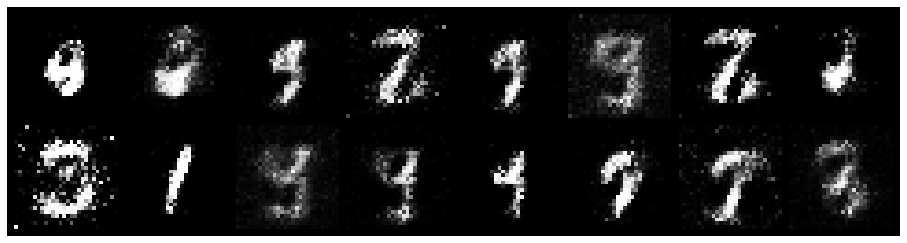

Epoch: [8/25], Batch Num: [500/600]
Discriminator Loss: 0.7101, Generator Loss: 2.5112
D(x): 0.7903, D(G(z)): 0.1667


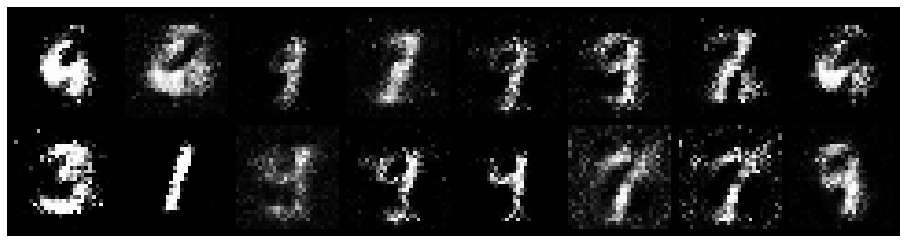

Epoch: [9/25], Batch Num: [0/600]
Discriminator Loss: 0.5782, Generator Loss: 2.4983
D(x): 0.8412, D(G(z)): 0.1860


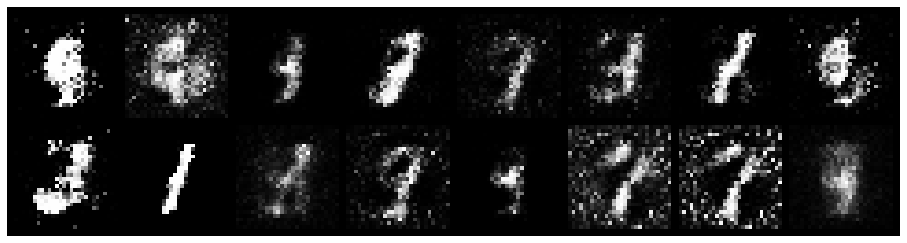

Epoch: [9/25], Batch Num: [100/600]
Discriminator Loss: 0.4924, Generator Loss: 2.6731
D(x): 0.9066, D(G(z)): 0.1761


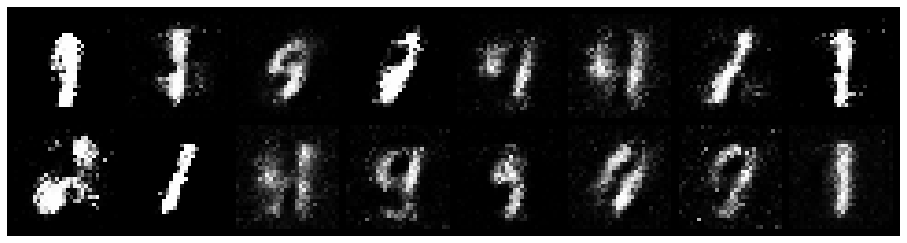

Epoch: [9/25], Batch Num: [200/600]
Discriminator Loss: 0.5007, Generator Loss: 2.6916
D(x): 0.8776, D(G(z)): 0.1945


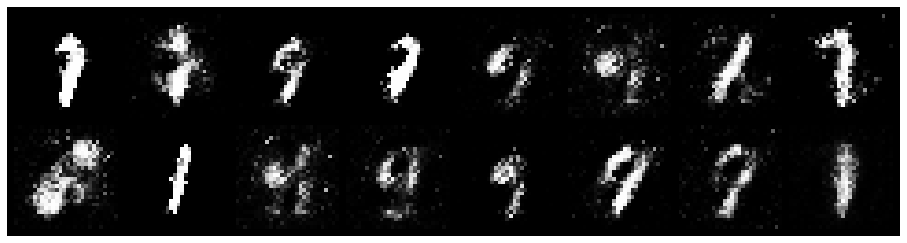

Epoch: [9/25], Batch Num: [300/600]
Discriminator Loss: 0.3800, Generator Loss: 2.9324
D(x): 0.8898, D(G(z)): 0.1239


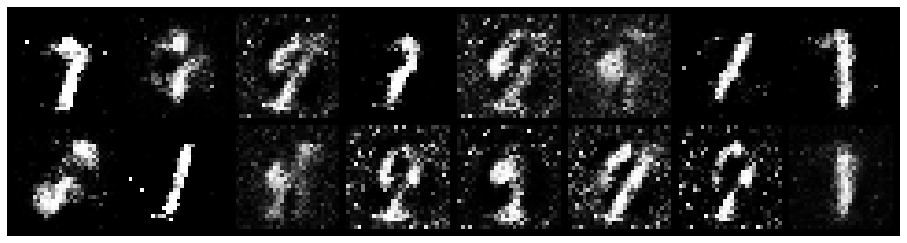

Epoch: [9/25], Batch Num: [400/600]
Discriminator Loss: 0.5657, Generator Loss: 2.1179
D(x): 0.8760, D(G(z)): 0.2363


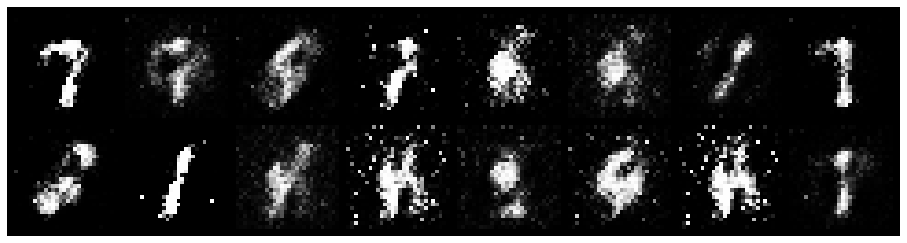

Epoch: [9/25], Batch Num: [500/600]
Discriminator Loss: 0.7599, Generator Loss: 2.0955
D(x): 0.7161, D(G(z)): 0.1998


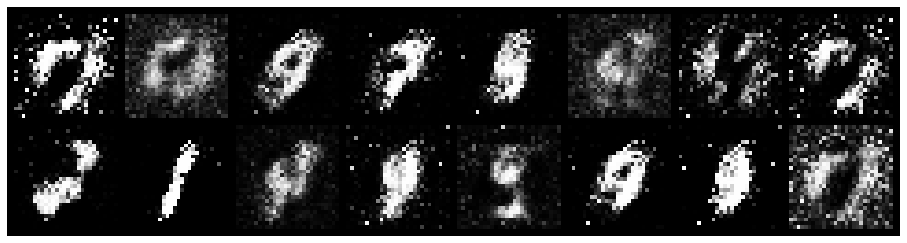

Epoch: [10/25], Batch Num: [0/600]
Discriminator Loss: 0.8253, Generator Loss: 2.5531
D(x): 0.8457, D(G(z)): 0.3189


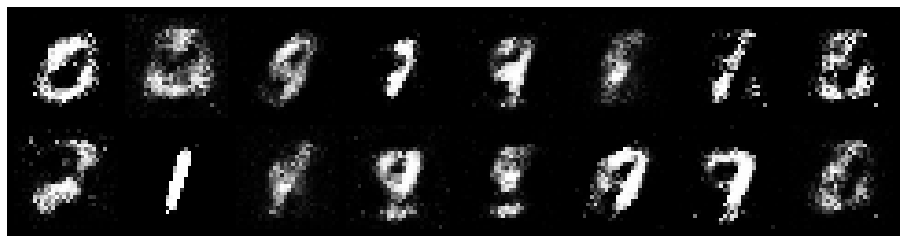

Epoch: [10/25], Batch Num: [100/600]
Discriminator Loss: 0.9162, Generator Loss: 2.4106
D(x): 0.7628, D(G(z)): 0.2602


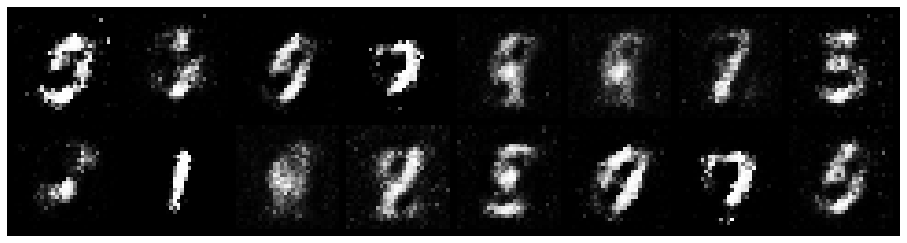

Epoch: [10/25], Batch Num: [200/600]
Discriminator Loss: 0.5722, Generator Loss: 2.4509
D(x): 0.8613, D(G(z)): 0.2058


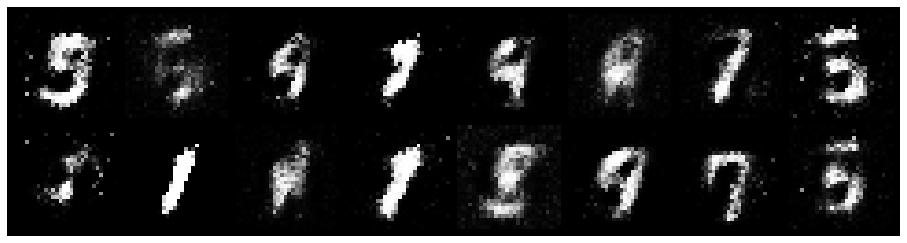

Epoch: [10/25], Batch Num: [300/600]
Discriminator Loss: 0.6084, Generator Loss: 2.4455
D(x): 0.7808, D(G(z)): 0.1743


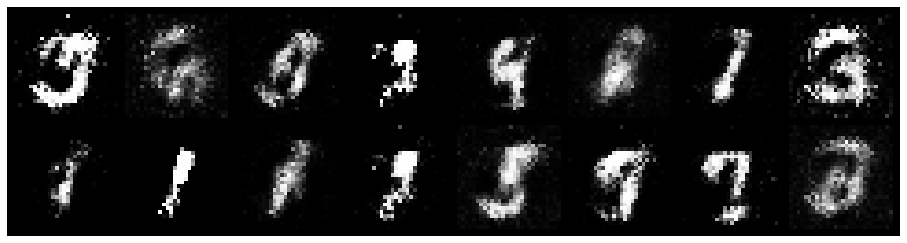

Epoch: [10/25], Batch Num: [400/600]
Discriminator Loss: 0.4447, Generator Loss: 2.9329
D(x): 0.8372, D(G(z)): 0.1275


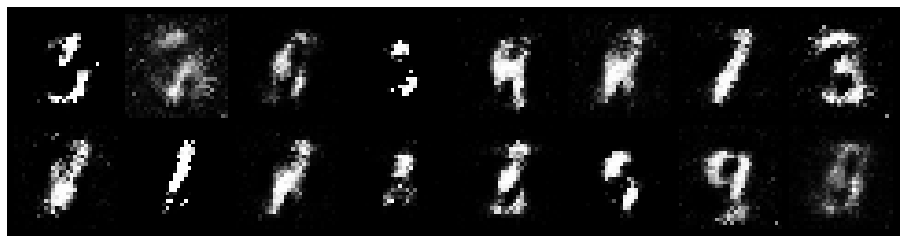

Epoch: [10/25], Batch Num: [500/600]
Discriminator Loss: 0.3909, Generator Loss: 3.1040
D(x): 0.8522, D(G(z)): 0.1084


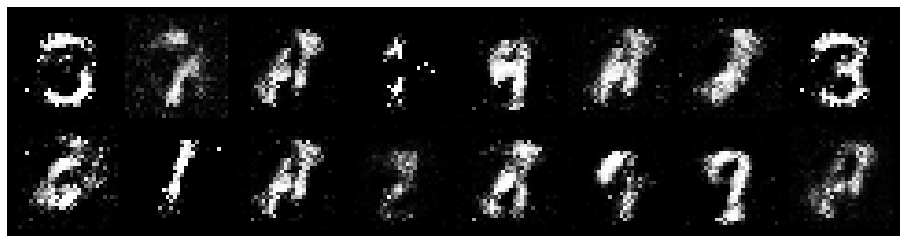

Epoch: [11/25], Batch Num: [0/600]
Discriminator Loss: 0.6442, Generator Loss: 2.4290
D(x): 0.7969, D(G(z)): 0.2243


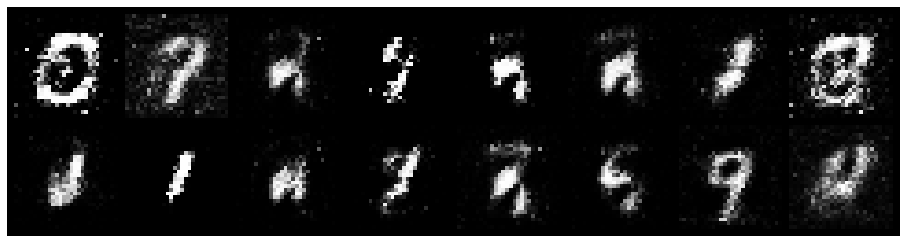

Epoch: [11/25], Batch Num: [100/600]
Discriminator Loss: 0.8765, Generator Loss: 1.7556
D(x): 0.7057, D(G(z)): 0.2591


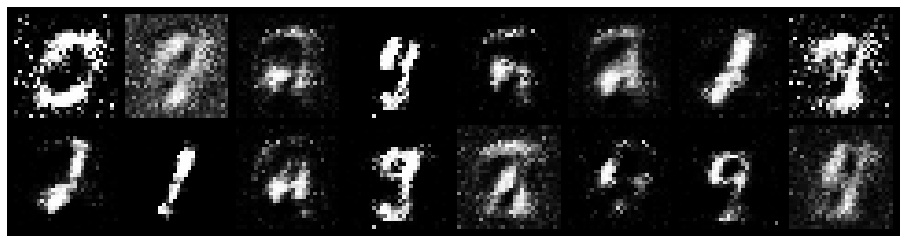

Epoch: [11/25], Batch Num: [200/600]
Discriminator Loss: 0.8649, Generator Loss: 2.4123
D(x): 0.7390, D(G(z)): 0.2065


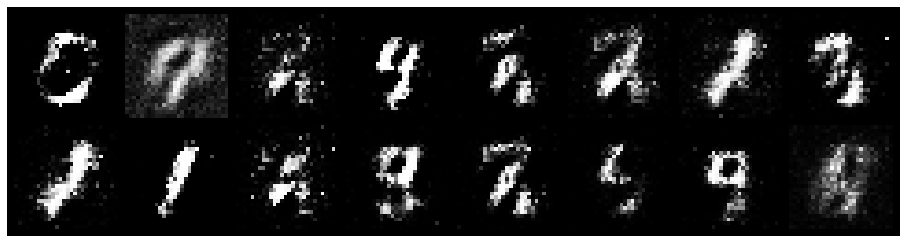

Epoch: [11/25], Batch Num: [300/600]
Discriminator Loss: 0.4902, Generator Loss: 2.3569
D(x): 0.8446, D(G(z)): 0.1875


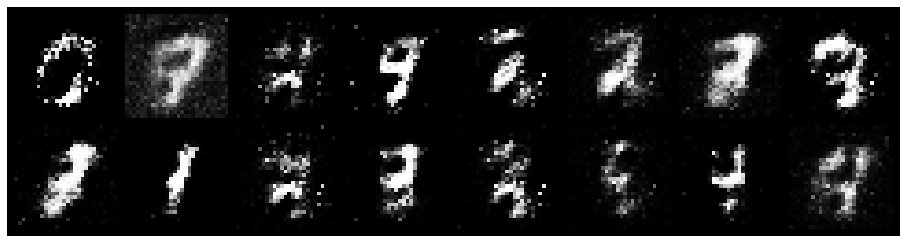

Epoch: [11/25], Batch Num: [400/600]
Discriminator Loss: 0.5322, Generator Loss: 2.9086
D(x): 0.8138, D(G(z)): 0.1257


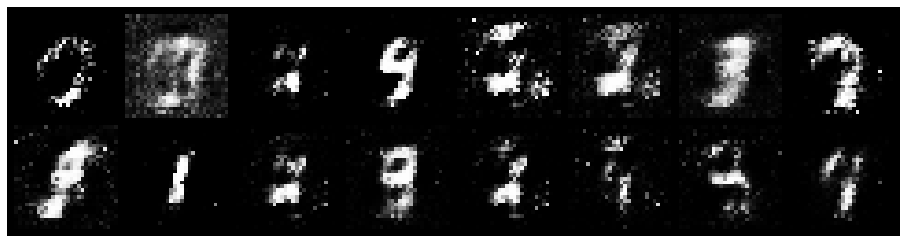

Epoch: [11/25], Batch Num: [500/600]
Discriminator Loss: 0.6156, Generator Loss: 2.0231
D(x): 0.7944, D(G(z)): 0.2178


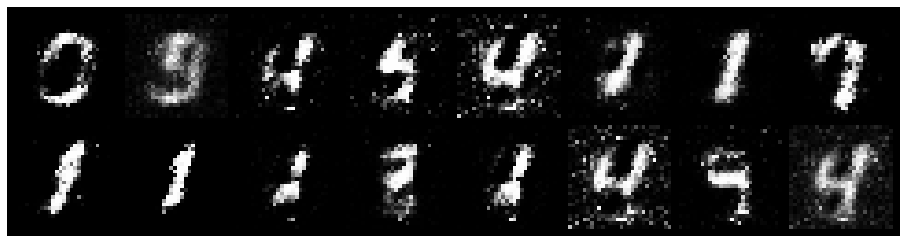

Epoch: [12/25], Batch Num: [0/600]
Discriminator Loss: 0.6504, Generator Loss: 2.6900
D(x): 0.8202, D(G(z)): 0.2303


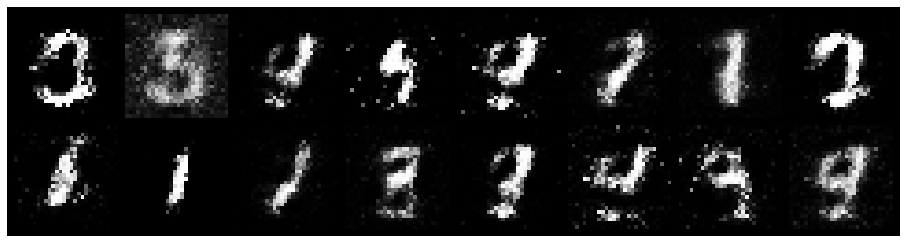

Epoch: [12/25], Batch Num: [100/600]
Discriminator Loss: 0.7697, Generator Loss: 1.6166
D(x): 0.8076, D(G(z)): 0.2796


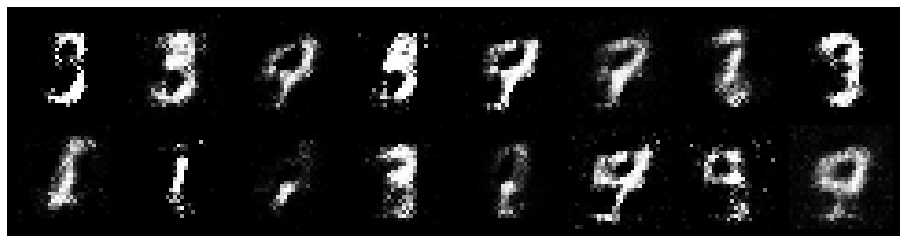

Epoch: [12/25], Batch Num: [200/600]
Discriminator Loss: 0.6551, Generator Loss: 2.5564
D(x): 0.8085, D(G(z)): 0.2144


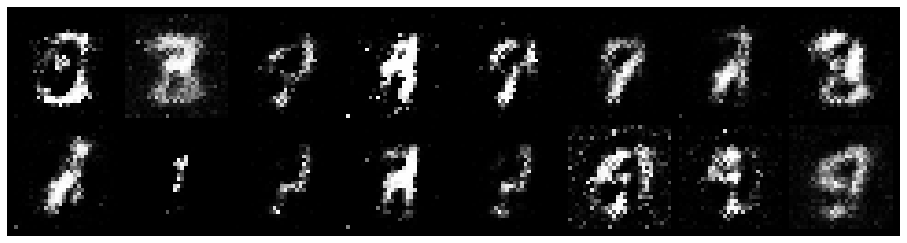

Epoch: [12/25], Batch Num: [300/600]
Discriminator Loss: 0.7978, Generator Loss: 2.2456
D(x): 0.7416, D(G(z)): 0.1822


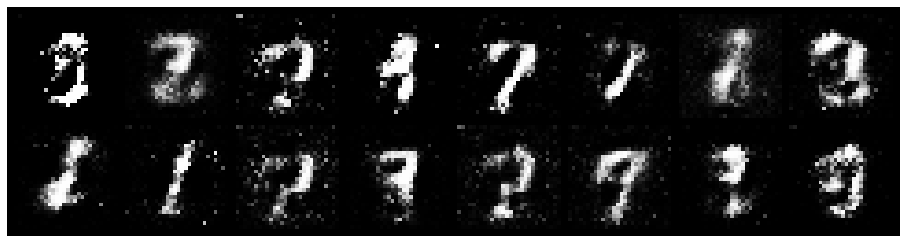

Epoch: [12/25], Batch Num: [400/600]
Discriminator Loss: 0.8355, Generator Loss: 2.0692
D(x): 0.7616, D(G(z)): 0.2660


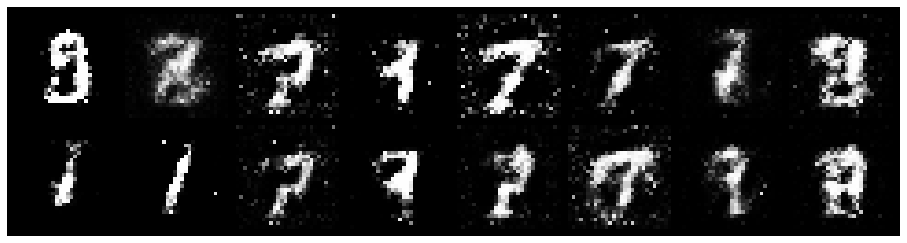

Epoch: [12/25], Batch Num: [500/600]
Discriminator Loss: 0.6209, Generator Loss: 2.5939
D(x): 0.8280, D(G(z)): 0.2046


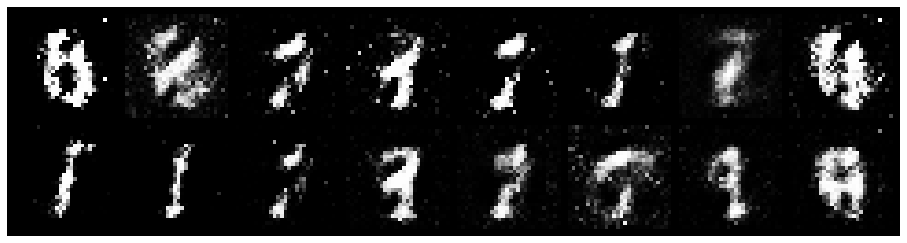

Epoch: [13/25], Batch Num: [0/600]
Discriminator Loss: 0.8123, Generator Loss: 1.5856
D(x): 0.7379, D(G(z)): 0.2666


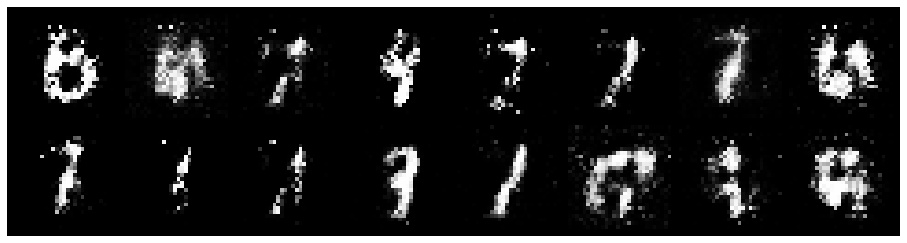

Epoch: [13/25], Batch Num: [100/600]
Discriminator Loss: 0.5765, Generator Loss: 2.2770
D(x): 0.7928, D(G(z)): 0.1617


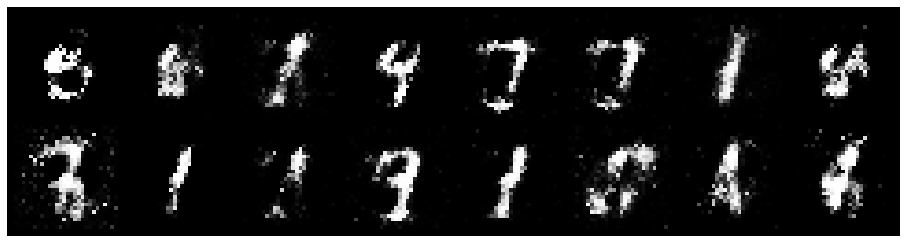

Epoch: [13/25], Batch Num: [200/600]
Discriminator Loss: 0.6809, Generator Loss: 1.6610
D(x): 0.7756, D(G(z)): 0.2538


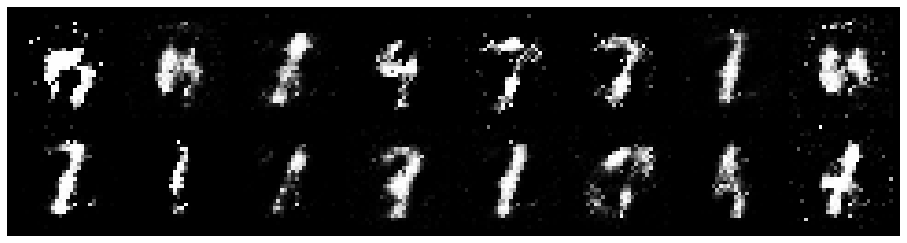

Epoch: [13/25], Batch Num: [300/600]
Discriminator Loss: 0.7150, Generator Loss: 1.6845
D(x): 0.7230, D(G(z)): 0.2141


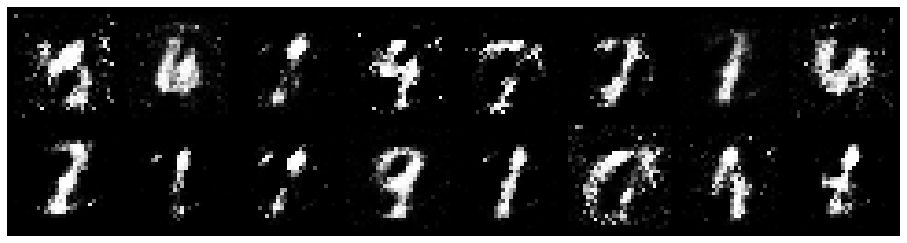

Epoch: [13/25], Batch Num: [400/600]
Discriminator Loss: 0.8374, Generator Loss: 2.3688
D(x): 0.7888, D(G(z)): 0.2771


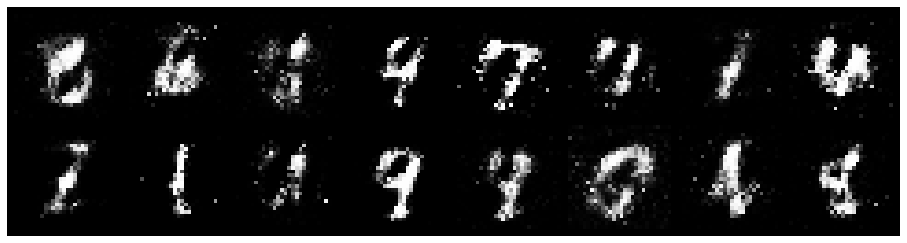

Epoch: [13/25], Batch Num: [500/600]
Discriminator Loss: 0.3995, Generator Loss: 3.3666
D(x): 0.8278, D(G(z)): 0.1039


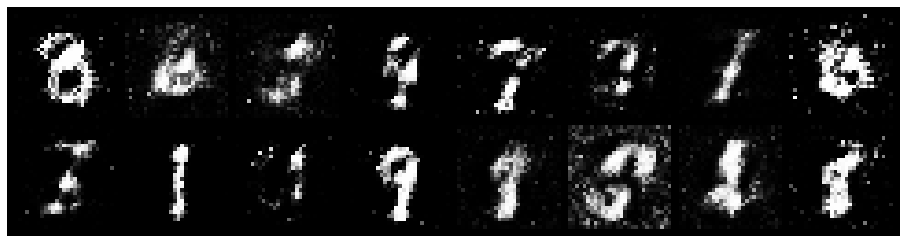

Epoch: [14/25], Batch Num: [0/600]
Discriminator Loss: 0.5126, Generator Loss: 1.7344
D(x): 0.8404, D(G(z)): 0.2204


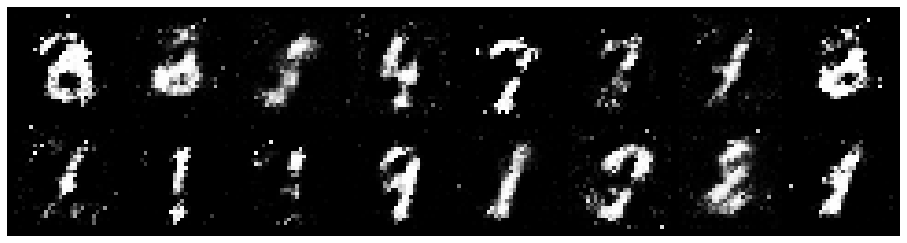

Epoch: [14/25], Batch Num: [100/600]
Discriminator Loss: 0.5779, Generator Loss: 2.0209
D(x): 0.8066, D(G(z)): 0.1898


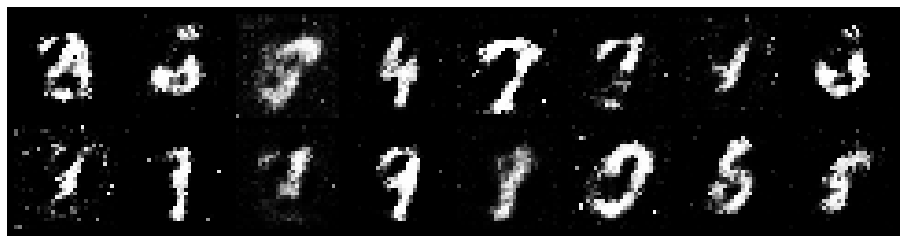

Epoch: [14/25], Batch Num: [200/600]
Discriminator Loss: 0.5922, Generator Loss: 2.3975
D(x): 0.8007, D(G(z)): 0.2030


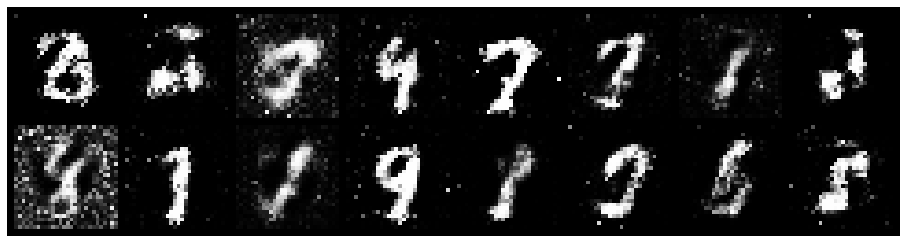

Epoch: [14/25], Batch Num: [300/600]
Discriminator Loss: 0.7882, Generator Loss: 2.5095
D(x): 0.7549, D(G(z)): 0.2211


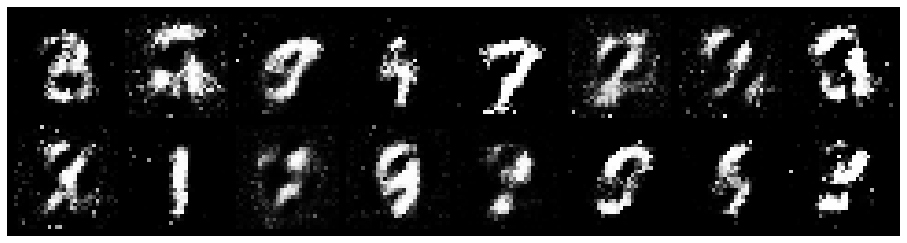

Epoch: [14/25], Batch Num: [400/600]
Discriminator Loss: 0.9706, Generator Loss: 1.8623
D(x): 0.6874, D(G(z)): 0.2576


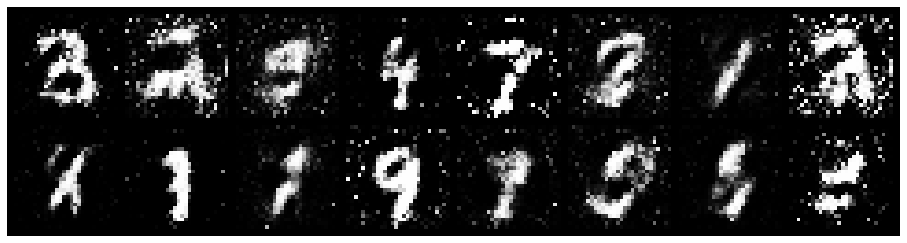

Epoch: [14/25], Batch Num: [500/600]
Discriminator Loss: 0.8514, Generator Loss: 1.9256
D(x): 0.7035, D(G(z)): 0.2243


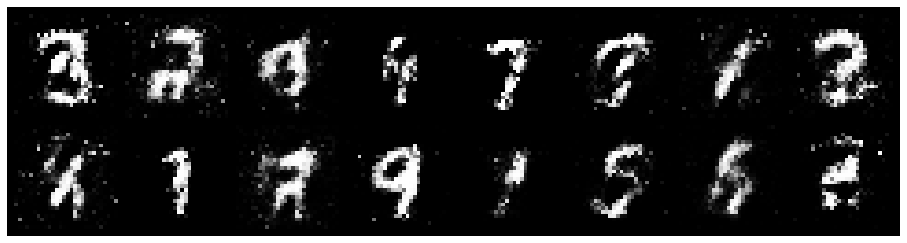

Epoch: [15/25], Batch Num: [0/600]
Discriminator Loss: 0.7140, Generator Loss: 2.2135
D(x): 0.7470, D(G(z)): 0.2076


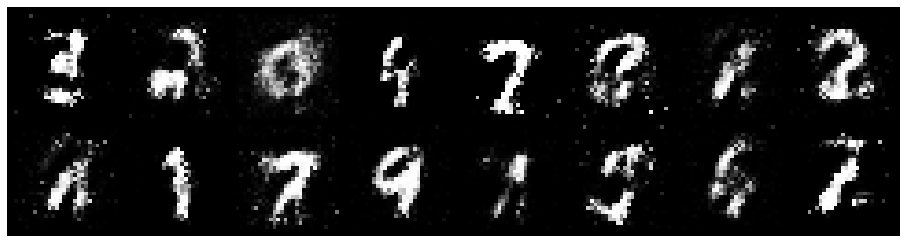

Epoch: [15/25], Batch Num: [100/600]
Discriminator Loss: 0.7908, Generator Loss: 1.7597
D(x): 0.7932, D(G(z)): 0.3253


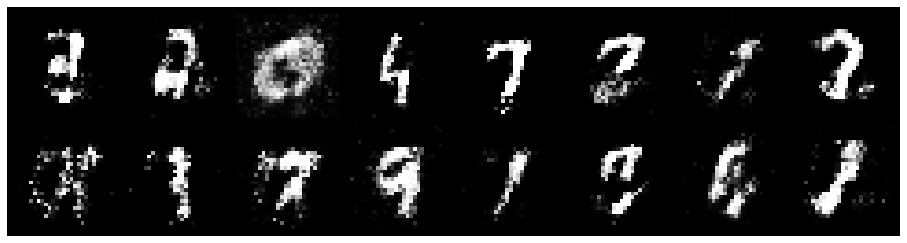

Epoch: [15/25], Batch Num: [200/600]
Discriminator Loss: 0.7808, Generator Loss: 1.7457
D(x): 0.7836, D(G(z)): 0.3060


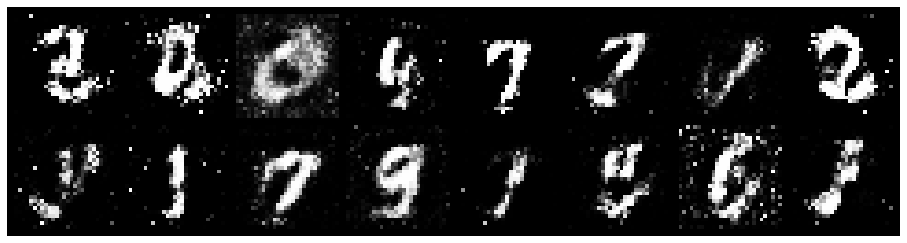

Epoch: [15/25], Batch Num: [300/600]
Discriminator Loss: 0.7966, Generator Loss: 1.5694
D(x): 0.8033, D(G(z)): 0.3495


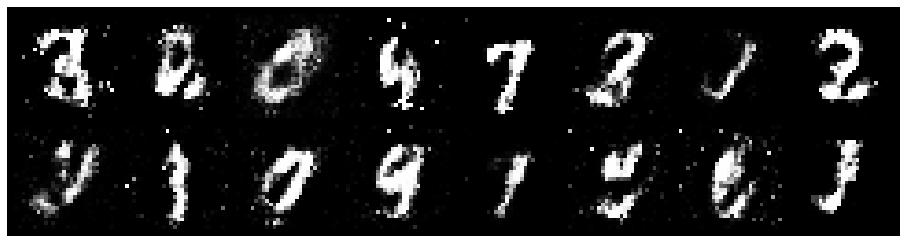

Epoch: [15/25], Batch Num: [400/600]
Discriminator Loss: 1.0439, Generator Loss: 1.5515
D(x): 0.7235, D(G(z)): 0.3218


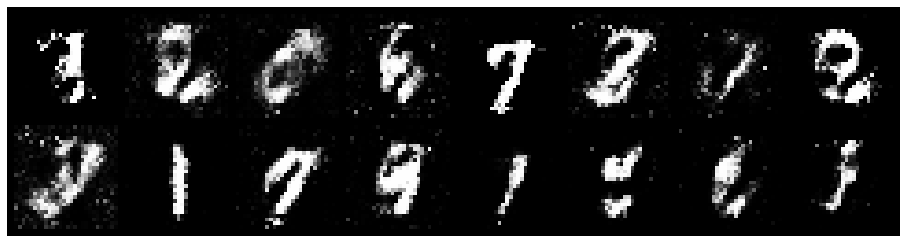

Epoch: [15/25], Batch Num: [500/600]
Discriminator Loss: 0.7970, Generator Loss: 1.6576
D(x): 0.7609, D(G(z)): 0.2304


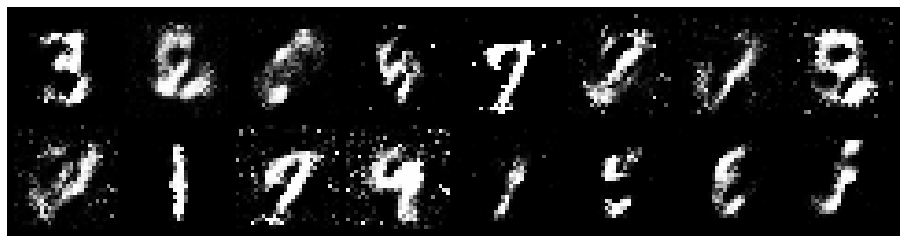

Epoch: [16/25], Batch Num: [0/600]
Discriminator Loss: 0.7791, Generator Loss: 2.0368
D(x): 0.6953, D(G(z)): 0.2005


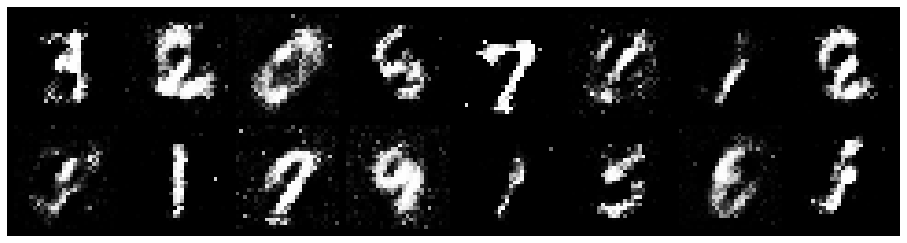

Epoch: [16/25], Batch Num: [100/600]
Discriminator Loss: 0.5696, Generator Loss: 2.0711
D(x): 0.8091, D(G(z)): 0.2171


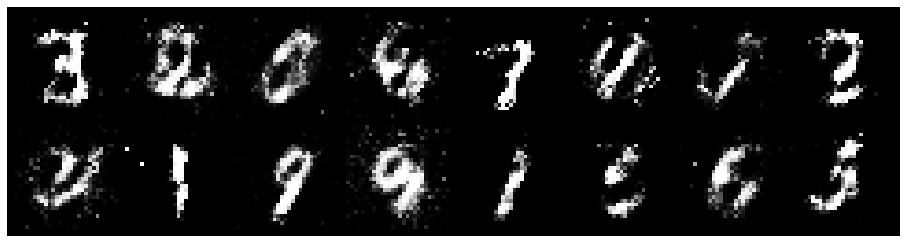

Epoch: [16/25], Batch Num: [200/600]
Discriminator Loss: 0.6745, Generator Loss: 2.2546
D(x): 0.7776, D(G(z)): 0.2254


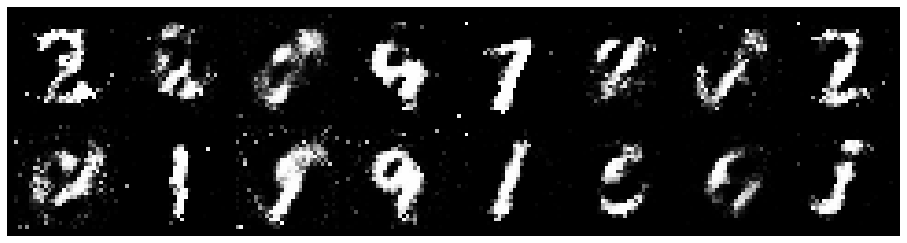

Epoch: [16/25], Batch Num: [300/600]
Discriminator Loss: 0.8393, Generator Loss: 2.3699
D(x): 0.7999, D(G(z)): 0.3079


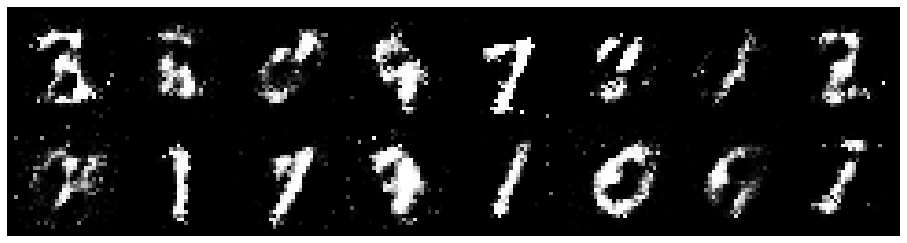

Epoch: [16/25], Batch Num: [400/600]
Discriminator Loss: 0.6016, Generator Loss: 2.2373
D(x): 0.8115, D(G(z)): 0.2267


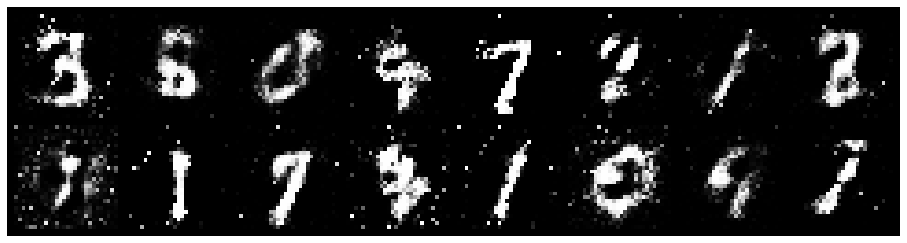

Epoch: [16/25], Batch Num: [500/600]
Discriminator Loss: 0.7358, Generator Loss: 1.8357
D(x): 0.7793, D(G(z)): 0.2447


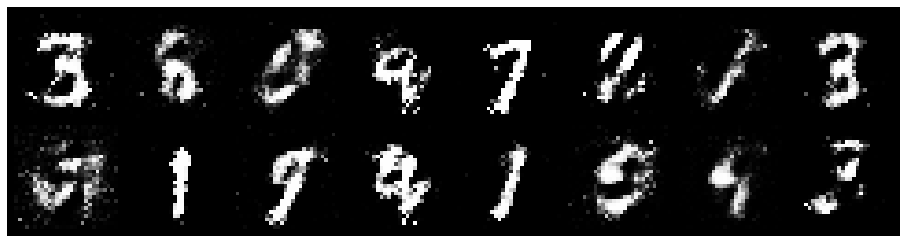

Epoch: [17/25], Batch Num: [0/600]
Discriminator Loss: 0.6432, Generator Loss: 2.1974
D(x): 0.7915, D(G(z)): 0.2486


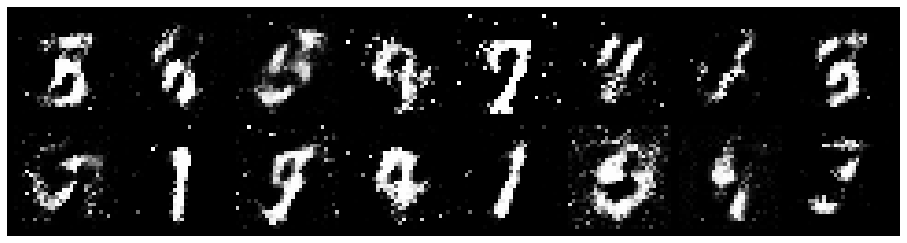

Epoch: [17/25], Batch Num: [100/600]
Discriminator Loss: 0.9014, Generator Loss: 1.3196
D(x): 0.7058, D(G(z)): 0.2901


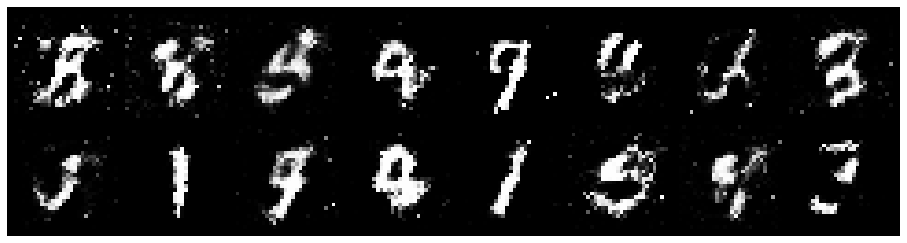

Epoch: [17/25], Batch Num: [200/600]
Discriminator Loss: 1.0060, Generator Loss: 1.5304
D(x): 0.7277, D(G(z)): 0.3550


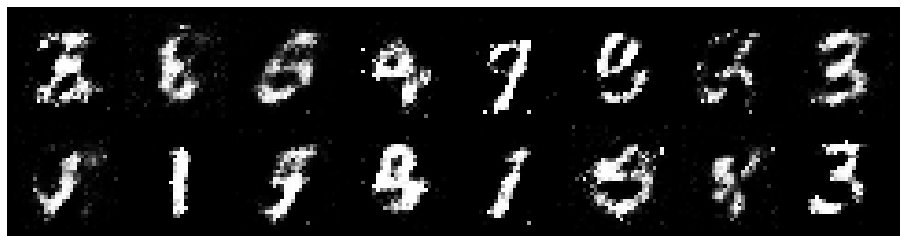

Epoch: [17/25], Batch Num: [300/600]
Discriminator Loss: 1.1499, Generator Loss: 1.2485
D(x): 0.6199, D(G(z)): 0.3741


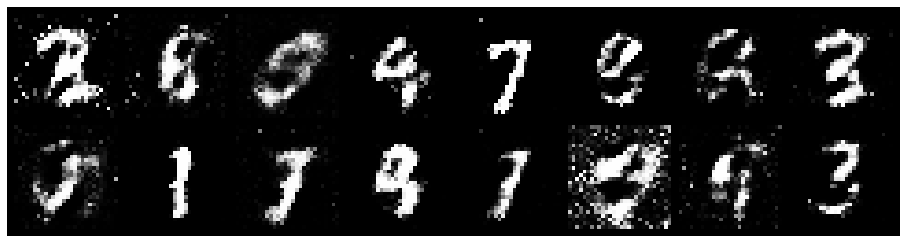

Epoch: [17/25], Batch Num: [400/600]
Discriminator Loss: 1.1351, Generator Loss: 1.6036
D(x): 0.7229, D(G(z)): 0.3896


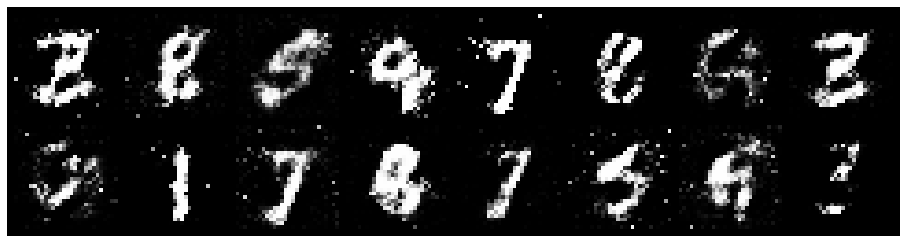

Epoch: [17/25], Batch Num: [500/600]
Discriminator Loss: 0.7776, Generator Loss: 1.5347
D(x): 0.7383, D(G(z)): 0.2770


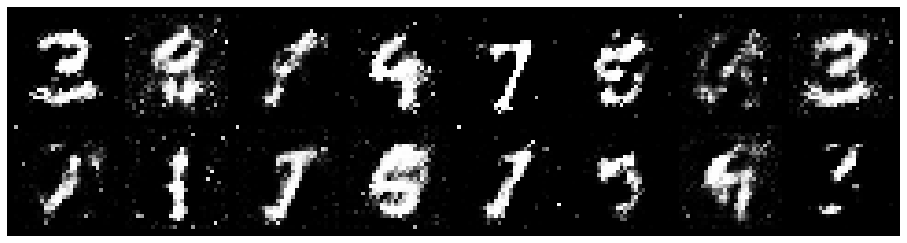

Epoch: [18/25], Batch Num: [0/600]
Discriminator Loss: 1.0119, Generator Loss: 1.3826
D(x): 0.6705, D(G(z)): 0.2965


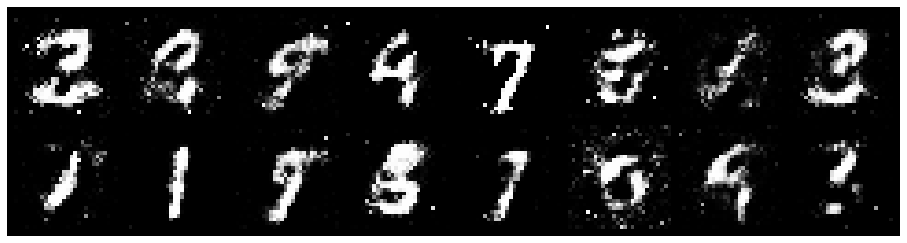

Epoch: [18/25], Batch Num: [100/600]
Discriminator Loss: 0.9809, Generator Loss: 1.6328
D(x): 0.6110, D(G(z)): 0.2510


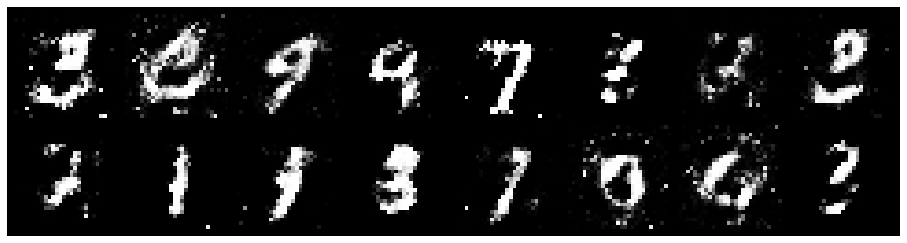

Epoch: [18/25], Batch Num: [200/600]
Discriminator Loss: 0.9464, Generator Loss: 1.4662
D(x): 0.7512, D(G(z)): 0.3770


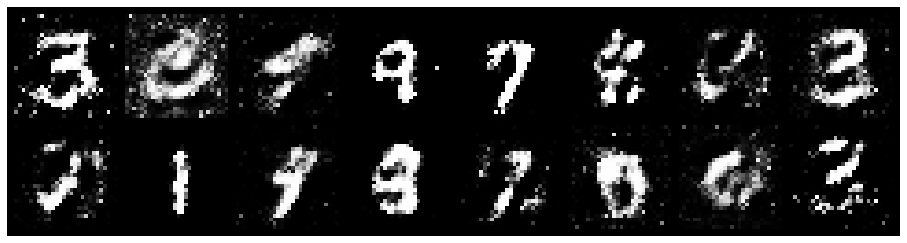

Epoch: [18/25], Batch Num: [300/600]
Discriminator Loss: 0.9876, Generator Loss: 1.7709
D(x): 0.6515, D(G(z)): 0.2799


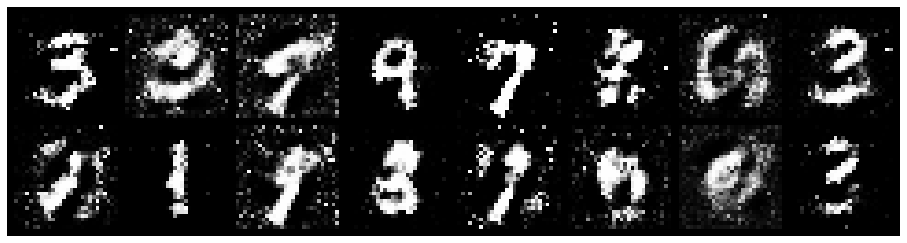

Epoch: [18/25], Batch Num: [400/600]
Discriminator Loss: 0.7405, Generator Loss: 1.8311
D(x): 0.7586, D(G(z)): 0.2447


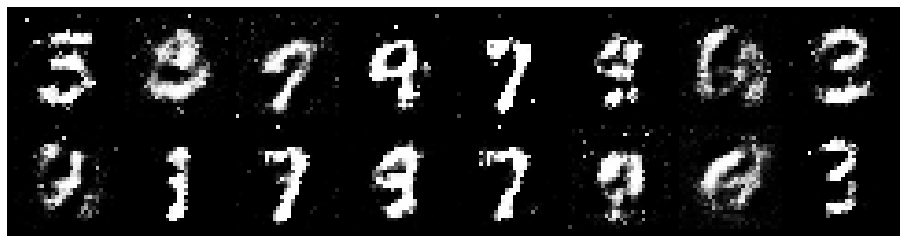

Epoch: [18/25], Batch Num: [500/600]
Discriminator Loss: 0.9139, Generator Loss: 1.8482
D(x): 0.7596, D(G(z)): 0.3176


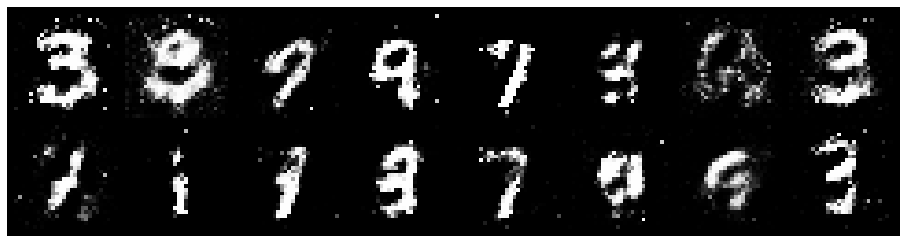

Epoch: [19/25], Batch Num: [0/600]
Discriminator Loss: 1.0268, Generator Loss: 2.0098
D(x): 0.7196, D(G(z)): 0.3421


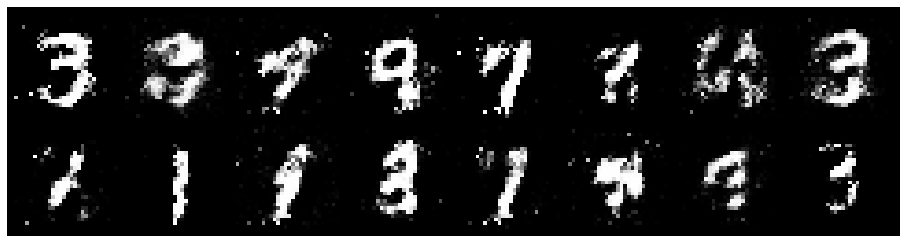

Epoch: [19/25], Batch Num: [100/600]
Discriminator Loss: 0.9045, Generator Loss: 1.0791
D(x): 0.6759, D(G(z)): 0.2488


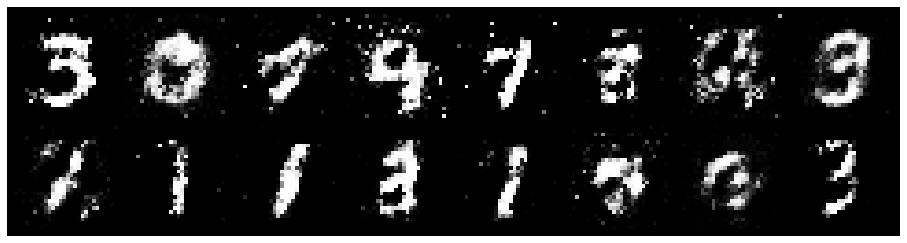

Epoch: [19/25], Batch Num: [200/600]
Discriminator Loss: 0.8182, Generator Loss: 1.5416
D(x): 0.6937, D(G(z)): 0.2500


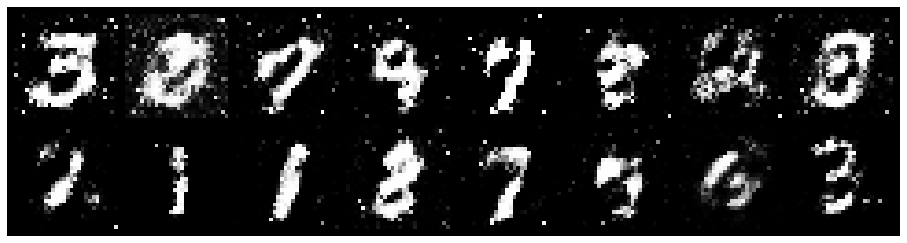

Epoch: [19/25], Batch Num: [300/600]
Discriminator Loss: 0.8682, Generator Loss: 1.2205
D(x): 0.7225, D(G(z)): 0.3182


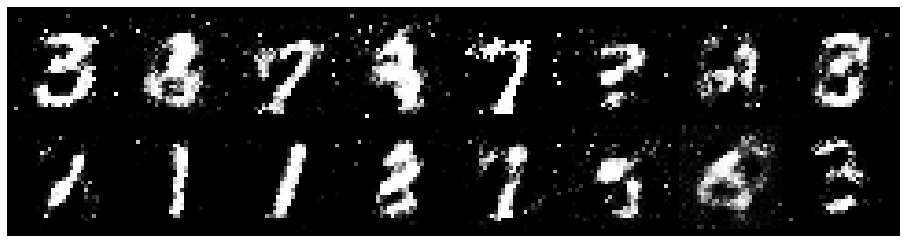

Epoch: [19/25], Batch Num: [400/600]
Discriminator Loss: 0.7892, Generator Loss: 1.5323
D(x): 0.7940, D(G(z)): 0.3343


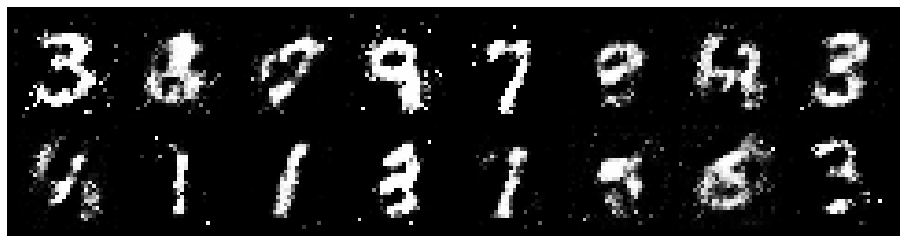

Epoch: [19/25], Batch Num: [500/600]
Discriminator Loss: 0.9011, Generator Loss: 1.4121
D(x): 0.7302, D(G(z)): 0.3118


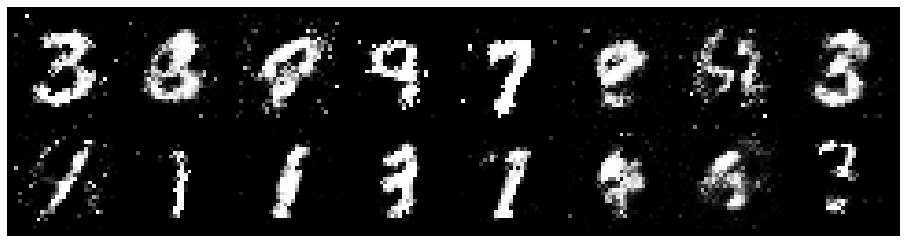

Epoch: [20/25], Batch Num: [0/600]
Discriminator Loss: 0.9741, Generator Loss: 1.9290
D(x): 0.6611, D(G(z)): 0.2488


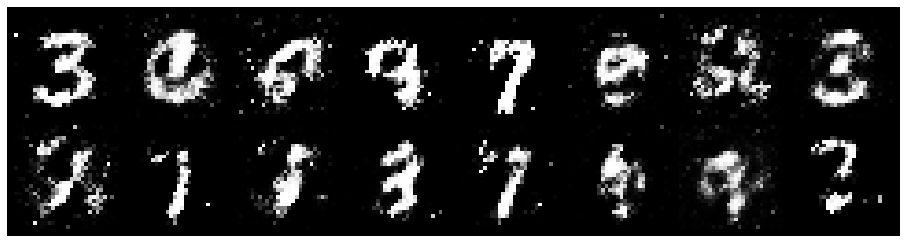

Epoch: [20/25], Batch Num: [100/600]
Discriminator Loss: 0.7810, Generator Loss: 1.8899
D(x): 0.7136, D(G(z)): 0.2468


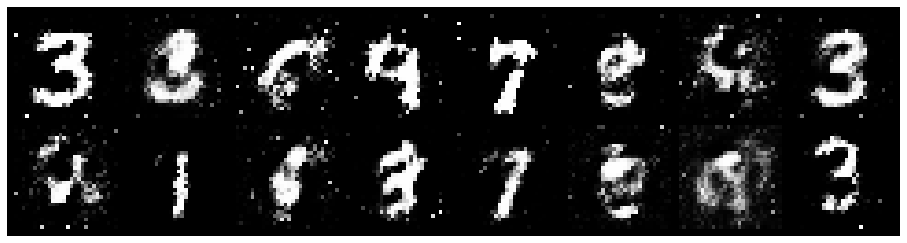

Epoch: [20/25], Batch Num: [200/600]
Discriminator Loss: 0.8212, Generator Loss: 1.8664
D(x): 0.6766, D(G(z)): 0.2455


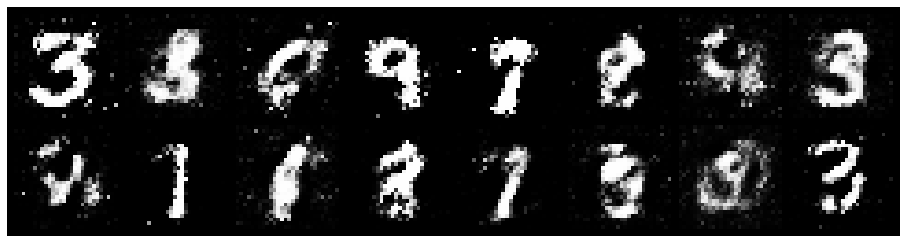

Epoch: [20/25], Batch Num: [300/600]
Discriminator Loss: 0.7770, Generator Loss: 1.8040
D(x): 0.7137, D(G(z)): 0.2494


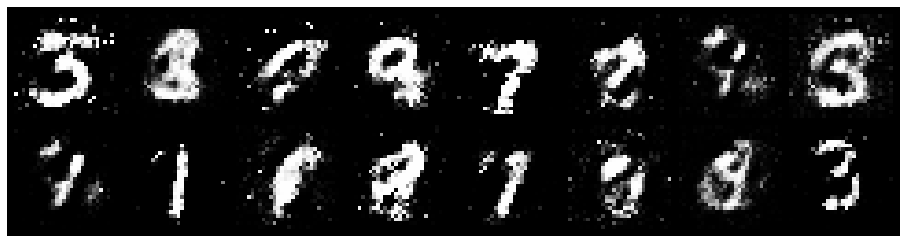

Epoch: [20/25], Batch Num: [400/600]
Discriminator Loss: 0.7123, Generator Loss: 1.8104
D(x): 0.8504, D(G(z)): 0.3190


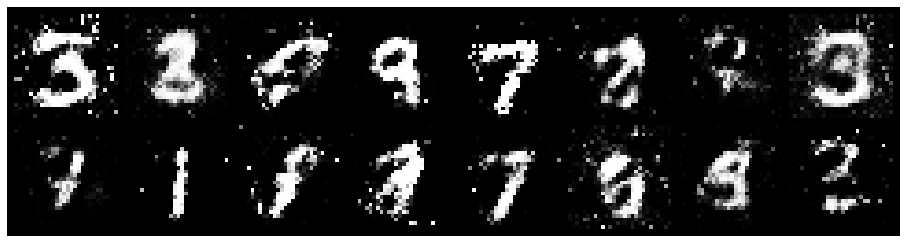

Epoch: [20/25], Batch Num: [500/600]
Discriminator Loss: 0.9302, Generator Loss: 1.9268
D(x): 0.7225, D(G(z)): 0.2978


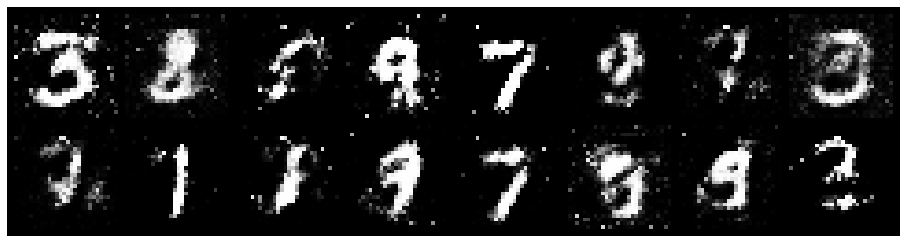

Epoch: [21/25], Batch Num: [0/600]
Discriminator Loss: 0.9389, Generator Loss: 2.1089
D(x): 0.6708, D(G(z)): 0.2166


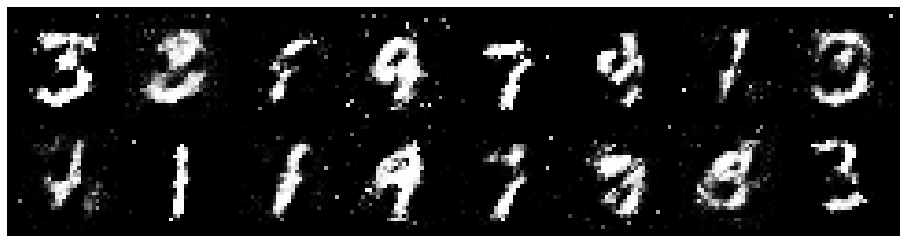

Epoch: [21/25], Batch Num: [100/600]
Discriminator Loss: 1.0266, Generator Loss: 1.4341
D(x): 0.7275, D(G(z)): 0.3797


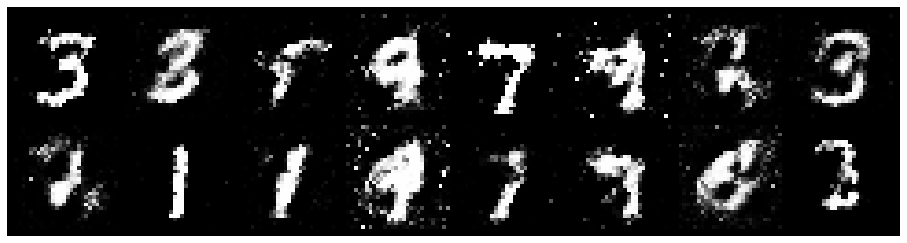

Epoch: [21/25], Batch Num: [200/600]
Discriminator Loss: 0.7596, Generator Loss: 1.5486
D(x): 0.8307, D(G(z)): 0.3287


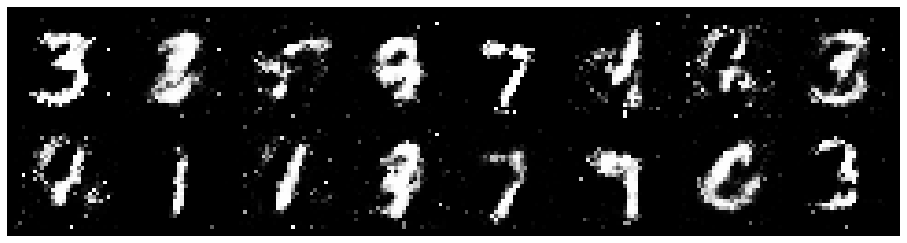

Epoch: [21/25], Batch Num: [300/600]
Discriminator Loss: 0.8384, Generator Loss: 1.8835
D(x): 0.6827, D(G(z)): 0.2319


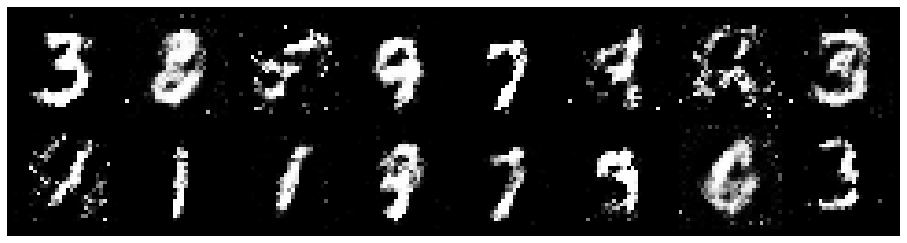

Epoch: [21/25], Batch Num: [400/600]
Discriminator Loss: 0.9756, Generator Loss: 1.0297
D(x): 0.6693, D(G(z)): 0.3576


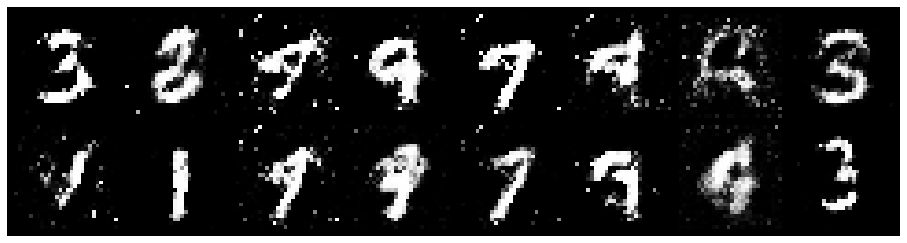

Epoch: [21/25], Batch Num: [500/600]
Discriminator Loss: 0.8381, Generator Loss: 1.7822
D(x): 0.7460, D(G(z)): 0.3070


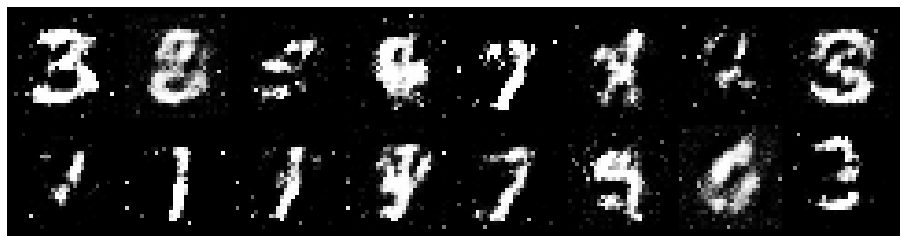

Epoch: [22/25], Batch Num: [0/600]
Discriminator Loss: 0.7638, Generator Loss: 1.8282
D(x): 0.7190, D(G(z)): 0.2519


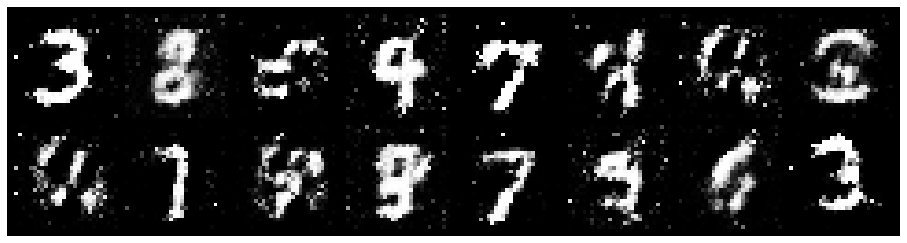

Epoch: [22/25], Batch Num: [100/600]
Discriminator Loss: 1.0544, Generator Loss: 1.1806
D(x): 0.7494, D(G(z)): 0.4147


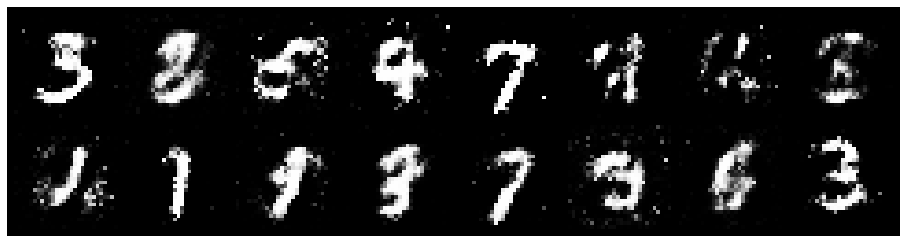

Epoch: [22/25], Batch Num: [200/600]
Discriminator Loss: 0.8000, Generator Loss: 1.9928
D(x): 0.7016, D(G(z)): 0.2246


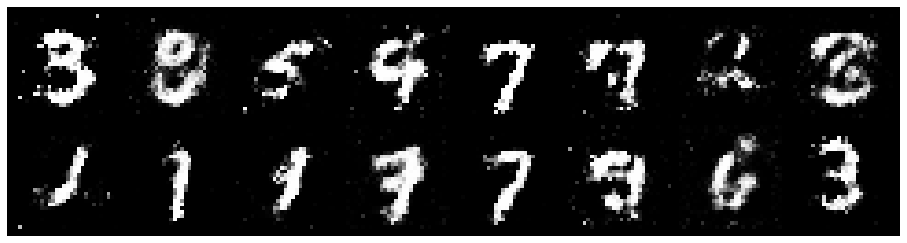

Epoch: [22/25], Batch Num: [300/600]
Discriminator Loss: 0.9910, Generator Loss: 1.3097
D(x): 0.6872, D(G(z)): 0.3482


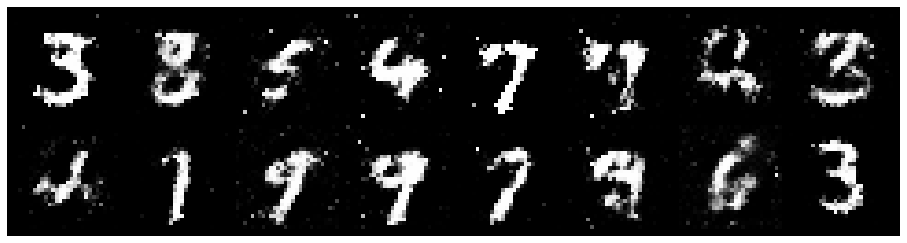

Epoch: [22/25], Batch Num: [400/600]
Discriminator Loss: 0.9712, Generator Loss: 1.6036
D(x): 0.6413, D(G(z)): 0.2803


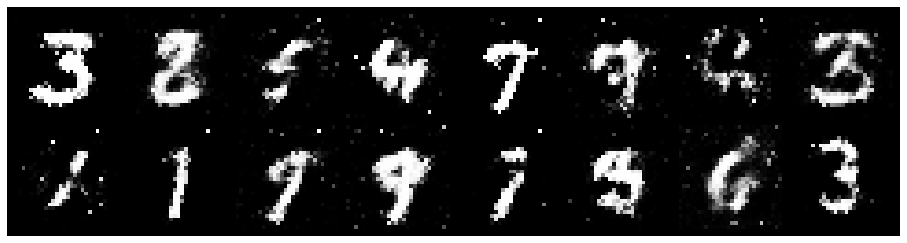

Epoch: [22/25], Batch Num: [500/600]
Discriminator Loss: 0.8854, Generator Loss: 1.3357
D(x): 0.7015, D(G(z)): 0.3003


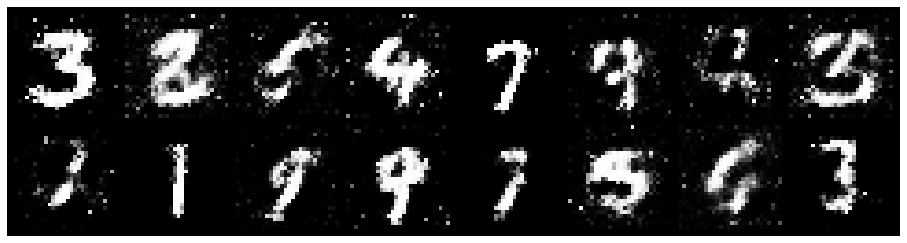

Epoch: [23/25], Batch Num: [0/600]
Discriminator Loss: 1.2656, Generator Loss: 1.8279
D(x): 0.6651, D(G(z)): 0.3294


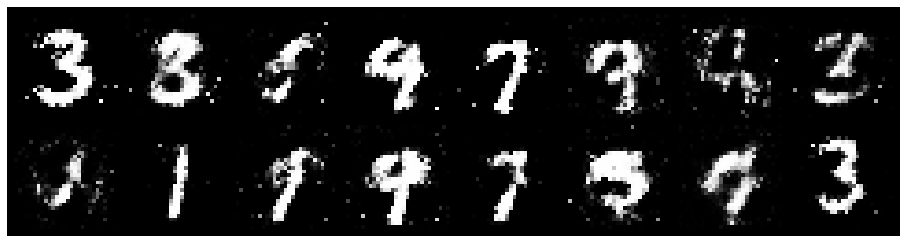

Epoch: [23/25], Batch Num: [100/600]
Discriminator Loss: 0.7687, Generator Loss: 1.6695
D(x): 0.8015, D(G(z)): 0.2902


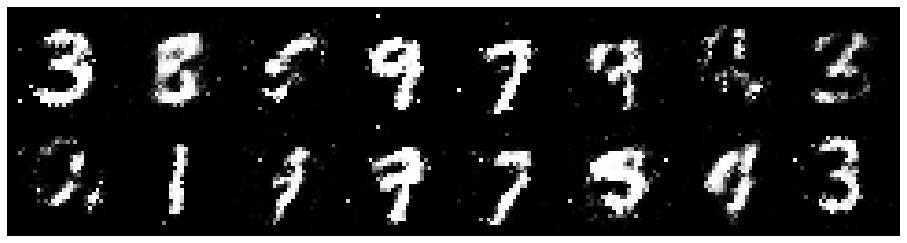

Epoch: [23/25], Batch Num: [200/600]
Discriminator Loss: 0.7664, Generator Loss: 1.4180
D(x): 0.7953, D(G(z)): 0.3331


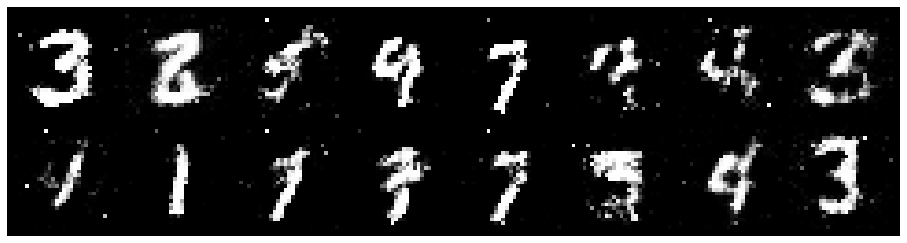

Epoch: [23/25], Batch Num: [300/600]
Discriminator Loss: 1.0947, Generator Loss: 1.3469
D(x): 0.6892, D(G(z)): 0.3627


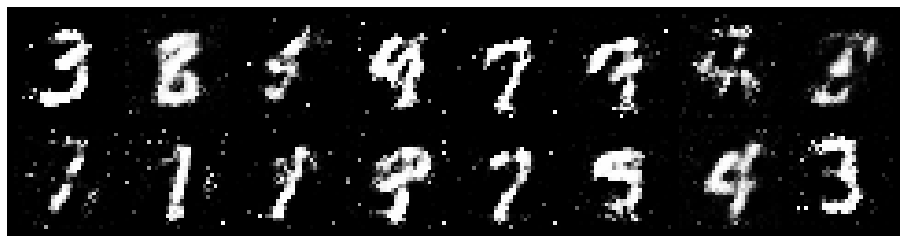

Epoch: [23/25], Batch Num: [400/600]
Discriminator Loss: 0.8940, Generator Loss: 2.0673
D(x): 0.6707, D(G(z)): 0.2501


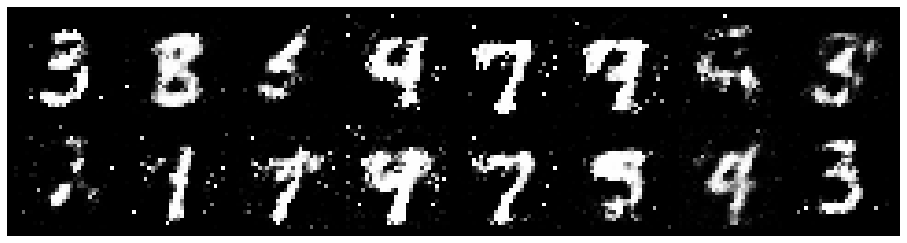

Epoch: [23/25], Batch Num: [500/600]
Discriminator Loss: 0.9172, Generator Loss: 1.4443
D(x): 0.7508, D(G(z)): 0.3368


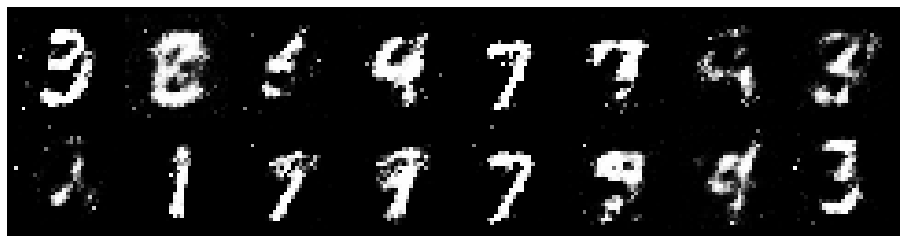

Epoch: [24/25], Batch Num: [0/600]
Discriminator Loss: 1.0126, Generator Loss: 1.6144
D(x): 0.6959, D(G(z)): 0.3328


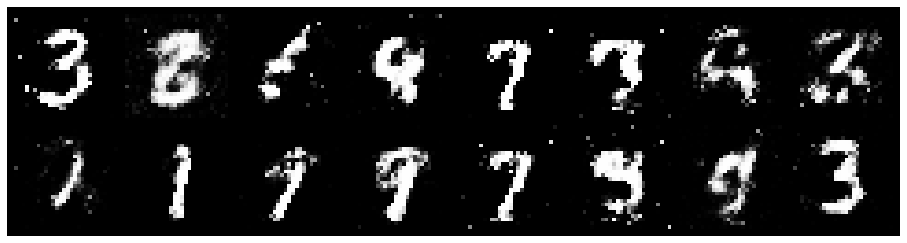

Epoch: [24/25], Batch Num: [100/600]
Discriminator Loss: 0.7189, Generator Loss: 2.2335
D(x): 0.7816, D(G(z)): 0.2541


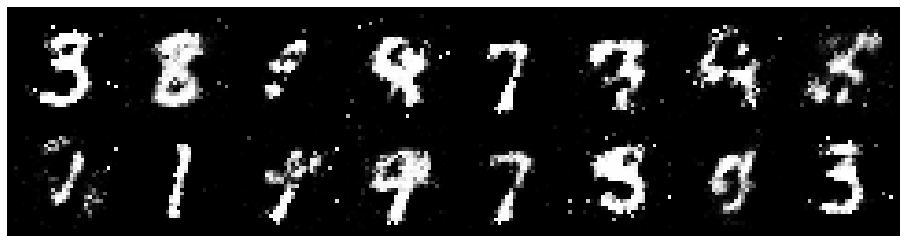

Epoch: [24/25], Batch Num: [200/600]
Discriminator Loss: 0.8004, Generator Loss: 1.7718
D(x): 0.7718, D(G(z)): 0.2936


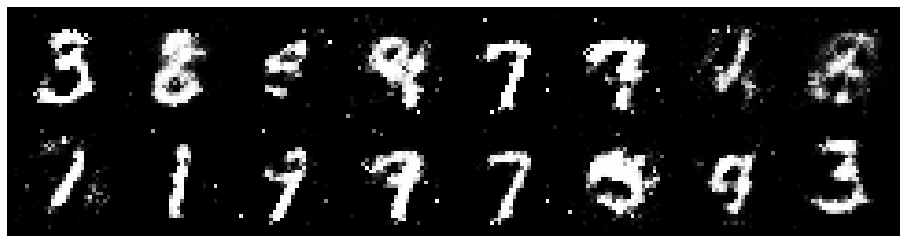

Epoch: [24/25], Batch Num: [300/600]
Discriminator Loss: 0.9635, Generator Loss: 1.3349
D(x): 0.7331, D(G(z)): 0.3529


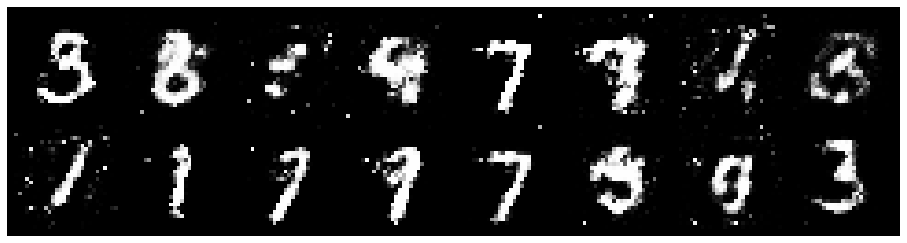

Epoch: [24/25], Batch Num: [400/600]
Discriminator Loss: 1.0516, Generator Loss: 1.4194
D(x): 0.6585, D(G(z)): 0.3410


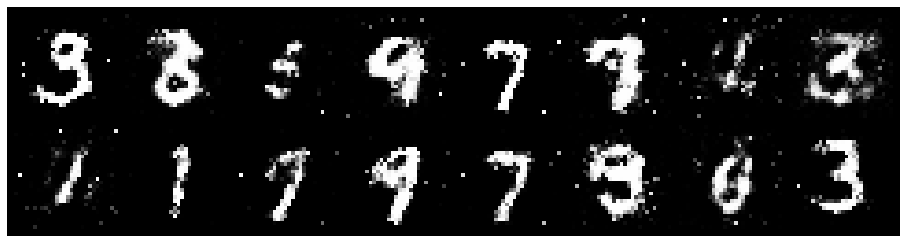

Epoch: [24/25], Batch Num: [500/600]
Discriminator Loss: 1.0266, Generator Loss: 1.4434
D(x): 0.7054, D(G(z)): 0.3509


In [15]:
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 25
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )